In [1]:
#installing dependencies
!pip install -q pyspark findspark

In [2]:
# Initialise Spark to locate Java dependencies
import findspark
findspark.init()

#Pyspark for distributed data processing
import pyspark
from pyspark.sql import SparkSession #initialise spark
from pyspark.sql.functions import col, sum as _sum

#import standard Python libraries for data analysis and visualization
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Plotting
from matplotlib import colormaps # Access to color maps for plotting
import math # Mathematical utilities

import seaborn as sns # Statistical data visualization

In [89]:
import statsmodels.api as sm

In [3]:
from statsmodels.tsa.stattools import adfuller, kpss

> **⚠️ Prerequisite Notice**  
> This notebook uses Apache Spark via PySpark.  
> Please ensure you have **Java (JDK 8 or 11)** installed and properly configured on your syste Make sure the `JAVA_HOME` environment variable is set correctly and that `java.exe` is accessible in your system PATH.H.
>  
> Without Java, the Spark session will fail to initiale.



In [4]:
# Create a Spark session for distributed processing
spark = SparkSession.builder \
    .appName("Search Trends Analysis") \
    .getOrCreate()

While the dataset used in this thesis is relatively small and could have been handled entirely within Python's Pandas framework, PySpark was initially selected for its scalability and potential for distributed data processing.

# Google Trends keywords SVI data

In [5]:
#read CSV using Spark
df_kw = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_search_trends_keywords.csv', header=True, inferSchema=True) #inferSchema added to automatically type inference for columns
df_agg = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_search_trends_aggregated.csv', header=True, inferSchema=True)

## Google Trends keywords

In [6]:
#show preview keywords
df_kw.show(3)
df_kw.printSchema()

+----------+--------+-------+---------+-----------------------+-----------------+---------------+-------------------+----------------------------+------------------------------+---------------+--------------+-----------------+----------------+---------------+----+---------------------+-------------------+--------------------------+------------------+-------------------+---------------------+-------------+------------------+------------------+---------------+-------------------+------------------------+------------------------+---------------+--------------------+------+----------------+---------+------------+-------+----------------+----------------+---------------------+----+-------+----------------+--------------------+-------------------+----------------+-------------------+--------------+------------------------+
|      date|carefour|carfour|carrefour|carrefour autour de moi|carrefour near me|carrefour drive|carrefour livraison|carrefour livraison domicile|carrefour livraison Ã dom

Several columns appear to have only zero values; let's drop them and keep a list of these.

In [7]:
# Exclude 'date' column from processing
columns_to_check = [c for c in df_kw.columns if c != 'date']

In [8]:
#Drop columns (keywords) with only zero values in their cells
kept_cols = []
dropped_cols = []

# Loop through numeric columns only
for c in columns_to_check:
    try:
        col_sum = df_kw.select(_sum(col(f"`{c}`"))).collect()[0][0]     # Calculate sum of each keyword column, backticks in col() to safely reference columns like `E.Leclerc`
        if col_sum == 0 or col_sum is None:
            dropped_cols.append(c)  # Drop if column has no valid data
        else:
            kept_cols.append(c)
    except Exception as e:
        print(f"Skipping column '{c}' due to error: {e}")
        dropped_cols.append(c)

In [9]:
#Construct final list of columns to retain, keep 'date' and valid keyword columns
final_cols = ['date'] + kept_cols

# Select cleaned/filtered DataFrame
df_kw = df_kw.select(*[col(c) if c == 'date' else col(f"`{c}`") for c in final_cols])

In [10]:
# Show results
print("Dropped columns (all values were 0 or null):")
print(dropped_cols)

Dropped columns (all values were 0 or null):
['carfour', 'carrefour near me', 'IntermarchÃ©', 'carrefour bourse']


✅ Dropped columns (all values were 0 or null):

`carfour`, `carrefour near me`, `IntermarchÃ©`, `carrefour bourse`.

In [11]:
# Preview the first 3 rows of the cleaned dataset
df_kw.show(3)

+----------+--------+---------+-----------------------+---------------+-------------------+----------------------------+------------------------------+---------------+--------------+-----------------+----------------+---------------+----+---------------------+-------------------+--------------------------+------------------+-------------------+---------------------+-------------+------------------+------------------+---------------+-------------------+------------------------+------------------------+---------------+--------------------+------+----------------+---------+-------+----------------+---------------------+----+-------+----------------+--------------------+-------------------+----------------+-------------------+--------------+------------------------+
|      date|carefour|carrefour|carrefour autour de moi|carrefour drive|carrefour livraison|carrefour livraison domicile|carrefour livraison Ã domicile|drive carrefour|carrefour city|carrefour express|carrefour market|carrefour 

### EDA

In [12]:
# Convert PySpark DataFrame to Pandas
df_kw = df_kw.toPandas()

In [13]:
# Check the dimensions of the DataFrame
df_kw.shape

(178, 44)

#### 1. Date Handling & Time Index Setup

The `date` is currently in ISO 8601 standard, `yyyy-mm-dd`, making it directly compatible with pandas and the libraries we will use.

However, we will convert the date to a Datetime object to fully utilise the time series functionalities. Lastly, we will set it as the DataFrame index, which converts the DataFrame into a time series for slicing, plotting, and modelling.

In [14]:
# Convert 'date' column to datetime and set as index
df_kw['date'] = pd.to_datetime(df_kw['date'])
df_kw.set_index('date', inplace=True)
df_kw.sort_index(inplace=True) #sorts data chronologically from earliest to latest data

#### 2. Time Series Grid of Keywords

In [15]:
# Set up subplot grid
n_keywords = len(df_kw.columns)
n_cols = 4
n_rows = math.ceil(n_keywords / n_cols)

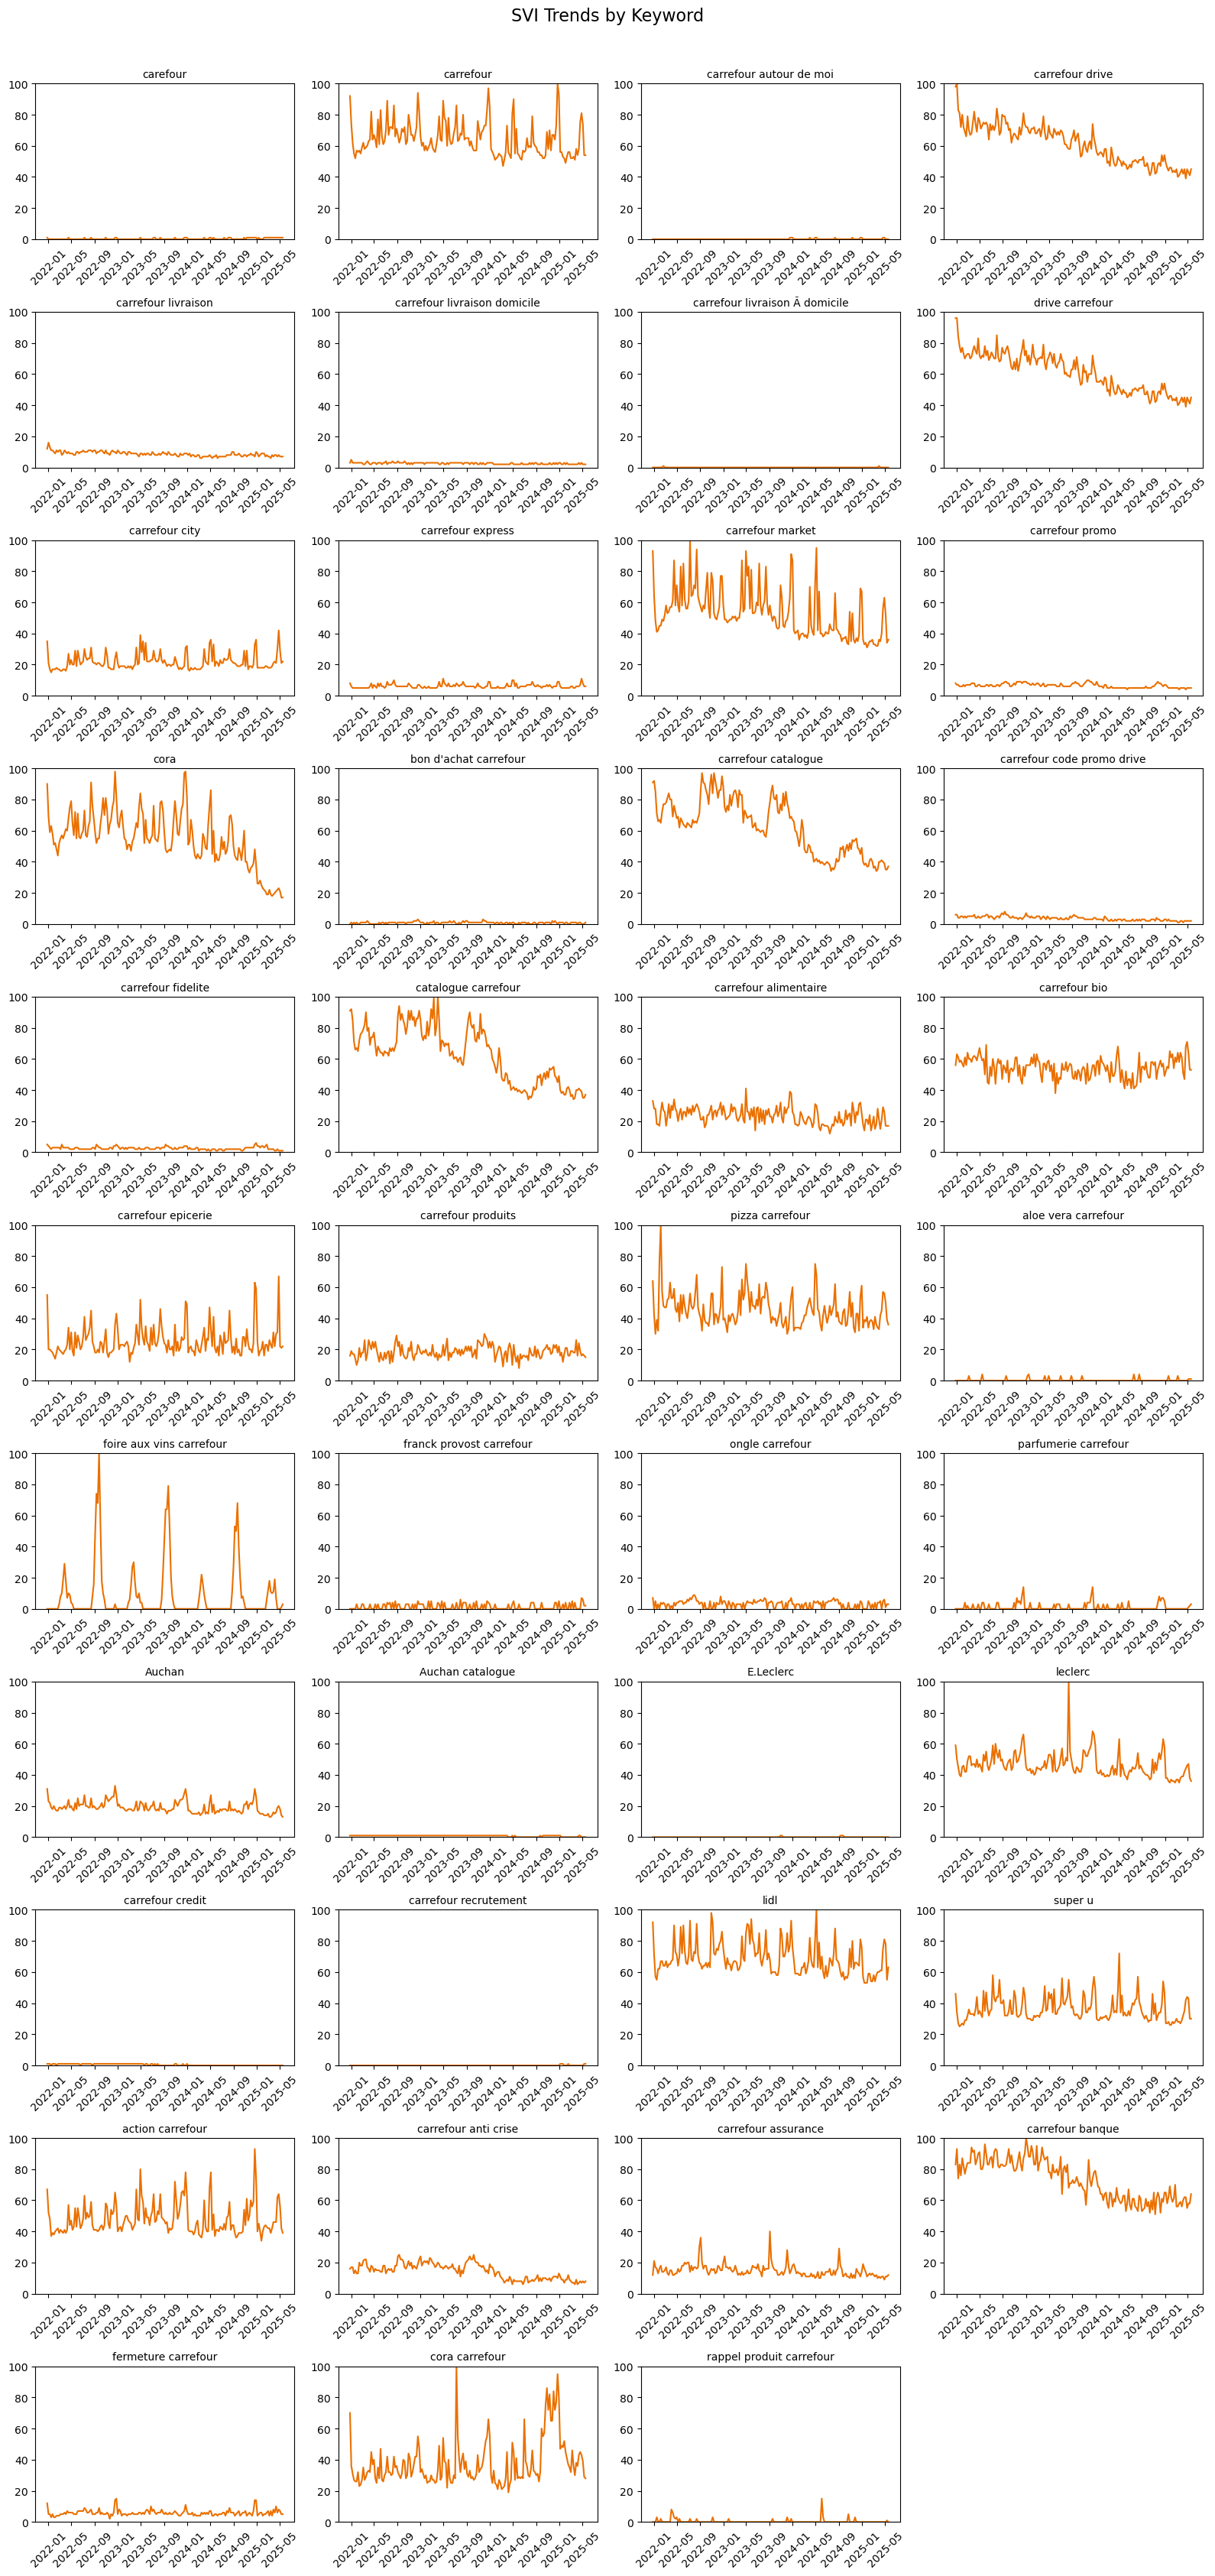

In [16]:
#plot grid
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, keyword in enumerate(df_kw.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(df_kw.index, df_kw[keyword], color='#EA7000')
    plt.title(keyword, fontsize=10)
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("SVI Trends by Keyword", fontsize=16, y=1.02)

#save figure as png
plt.savefig('svi_keyword_trends.png', bbox_inches='tight', dpi=300)

plt.show()

As expected based on the literature review, we observe considerable variability in search popularity over time for most keywords, with episodic peaks in search interest. We can also see the sudden rise in popularity of some keywords over time and the decline of others.

#### 3. Distribution Plot of Interest Scores

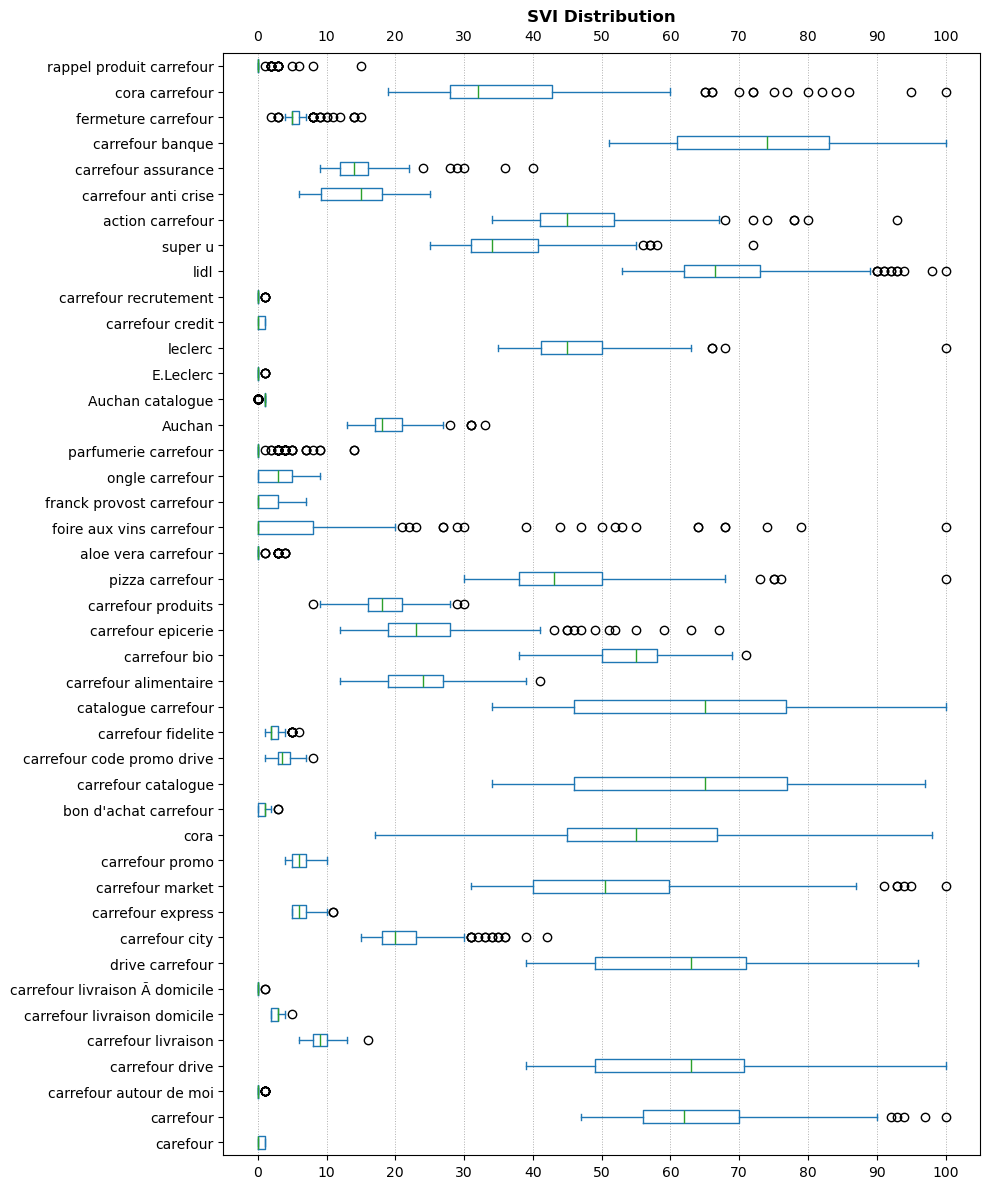

In [17]:
# Create horizontal boxplots for each keyword's SVI distribution
df_kw.plot(kind='box', vert=False, figsize=(10, 12), title='SVI Distribution')
plt.title('SVI Distribution', fontweight='bold')
plt.tick_params(axis='x', which='both', labeltop=True)
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.xticks(np.arange(0, 110, 10))
plt.tight_layout()

#save figure as png
plt.savefig('svi_distribution_boxplot.png', bbox_inches='tight', dpi=300)

plt.show()

#### 4. Statistical Summary

In [18]:
# Generate summary statistics for all keywords
summary = df_kw.describe().T

In [19]:
# Compute additional statistics: range, IQR, skew, kurtosis, volatility
summary["range"] = summary["max"] - summary["min"]
summary["iqr"] = summary["75%"] - summary["25%"] #interquartile range
summary["skew"] = df_kw.skew()
summary["kurtosis"] = df_kw.kurtosis()
summary["volatility (std/mean)"] = summary["std"] / summary["mean"]

In [20]:
# Display the updated summary statistics
summary

,count,mean,std,min,25%,50%,75%,max,range,iqr,skew,kurtosis,volatility (std/mean)
carefour,178.0,0.269663,0.445037,0.0,0.00,0.0,1.00,1.0,1.0,1.00,1.046901,-0.914401,1.650344
carrefour,178.0,64.342697,10.632031,47.0,56.00,62.0,70.00,100.0,53.0,14.00,1.060975,0.806986,0.165241
carrefour autour de moi,178.0,0.067416,0.251448,0.0,0.00,0.0,0.00,1.0,1.0,0.00,3.479846,10.224086,3.729811
carrefour drive,178.0,61.028090,12.453498,39.0,49.00,63.0,70.75,100.0,61.0,21.75,0.178096,-0.572171,0.204062
carrefour livraison,178.0,8.707865,1.466787,6.0,8.00,9.0,10.00,16.0,10.0,2.00,0.887543,2.499696,0.168444
carrefour livraison domicile,178.0,2.606742,0.574761,2.0,2.00,3.0,3.00,5.0,3.0,1.00,0.475760,0.394989,0.220490
carrefour livraison Ã domicile,178.0,0.011236,0.105700,0.0,0.00,0.0,0.00,1.0,1.0,0.00,9.353236,86.454352,9.407294
drive carrefour,178.0,61.067416,12.420866,39.0,49.00,63.0,71.00,96.0,57.0,22.00,0.098069,-0.837158,0.203396
carrefour city,178.0,21.747191,5.084386,15.0,18.00,20.0,23.00,42.0,27.0,5.00,1.539816,2.079072,0.233795
carrefour express,178.0,6.213483,1.288558,5.0,5.00,6.0,7.00,11.0,6.0,2.00,1.436954,2.065717,0.207381


##### Mean
A few keywords stand above the others with a mean above 60, indicating dominant and sustained search behaviour: 
"carrefour banque" ~73, "lidl" ~68, "carrefour" ~64, "catalogue carrefour"	~62, "carrefour catalogue"	~62, "drive carrefour"	~61, "carrefour drive"	~61

##### Standard Deviation
With a sigma above ~17, the following keywords showcase the highest volatility in search patterns: "catalogue carrefour", "carrefour catalogue", "cora", "foire aux vins carrefour".

##### Range (max-min)
Several FMCG-related and brand name keywords are acarcterised with wide fluctuations in attention (range above 50): "foire aux vins carrefour", "pizza carrefour", "carrefour", "cora carrefour", "cora", "carrefour market", "leclerc".

##### Skewness and Kurtosis
A few keywords have a negative skew, with only "Auchan catalogue" having a skewness above -1.0. Interestingly, "carrefour livraison Ã domicile", "rappel produit carrefour", "E.Leclerc" and "carrefour recrutement" have a significant positive skeweness (all above +5.0), indicating a low search interest with occasional spikes in interest. These same keywords are also the ones with the highest kurtosis, suggesting strong event-driven behaviour. Based on the meaning of the keywords, we can see that this is possibly related to news or exceptional occasions ("rappel produit carrefour" and "E.Leclerc") or seasonal events ("carrefour recrutement").

##### Volatility (std/mean)
Based on the data, we can set the volatility thresholds as follows:
* below 0.20 Low: most of these keywords are brand equity
* 0.20 – 0.50 Medium: keywords here seem to be related to FMCG sales cycles
* 0.50 – 1.0 High: keywords in this group are possibly linked to events as they have high variance in consumer interest.
* above 1.0 Very High: these keywords might be helpful for short-term forecasting or anomaly analysis.

#### 5. Missing Values Analysis
Check how much missing and flat data there is with visuals.

In [21]:
# Check for any columns with missing values
missing = df_kw.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("Columns with missing values:")
    print(missing)
else:
    print("No missing values found.")


No missing values found.


In [22]:
# Check how many zero values exist per column
zeros = (df_kw == 0).sum()
zeros = zeros[zeros > 0]

if not zeros.empty:
    print("Number of zeros in columns:")
    print(zeros)
else:
    print("No columns with zeros values found.")


Number of zeros in columns:
carefour                          130
carrefour autour de moi           166
carrefour livraison Ã domicile    176
bon d'achat carrefour              52
aloe vera carrefour               161
foire aux vins carrefour          109
franck provost carrefour          112
ongle carrefour                    51
parfumerie carrefour              134
Auchan catalogue                   40
E.Leclerc                         173
carrefour credit                   99
carrefour recrutement             172
rappel produit carrefour          158
dtype: int64


Keywords with many zero values might have episodic or accidental search interest; these will be monitored throughout the rest of the EDA.

#### 6. Keyword Correlation Matrix

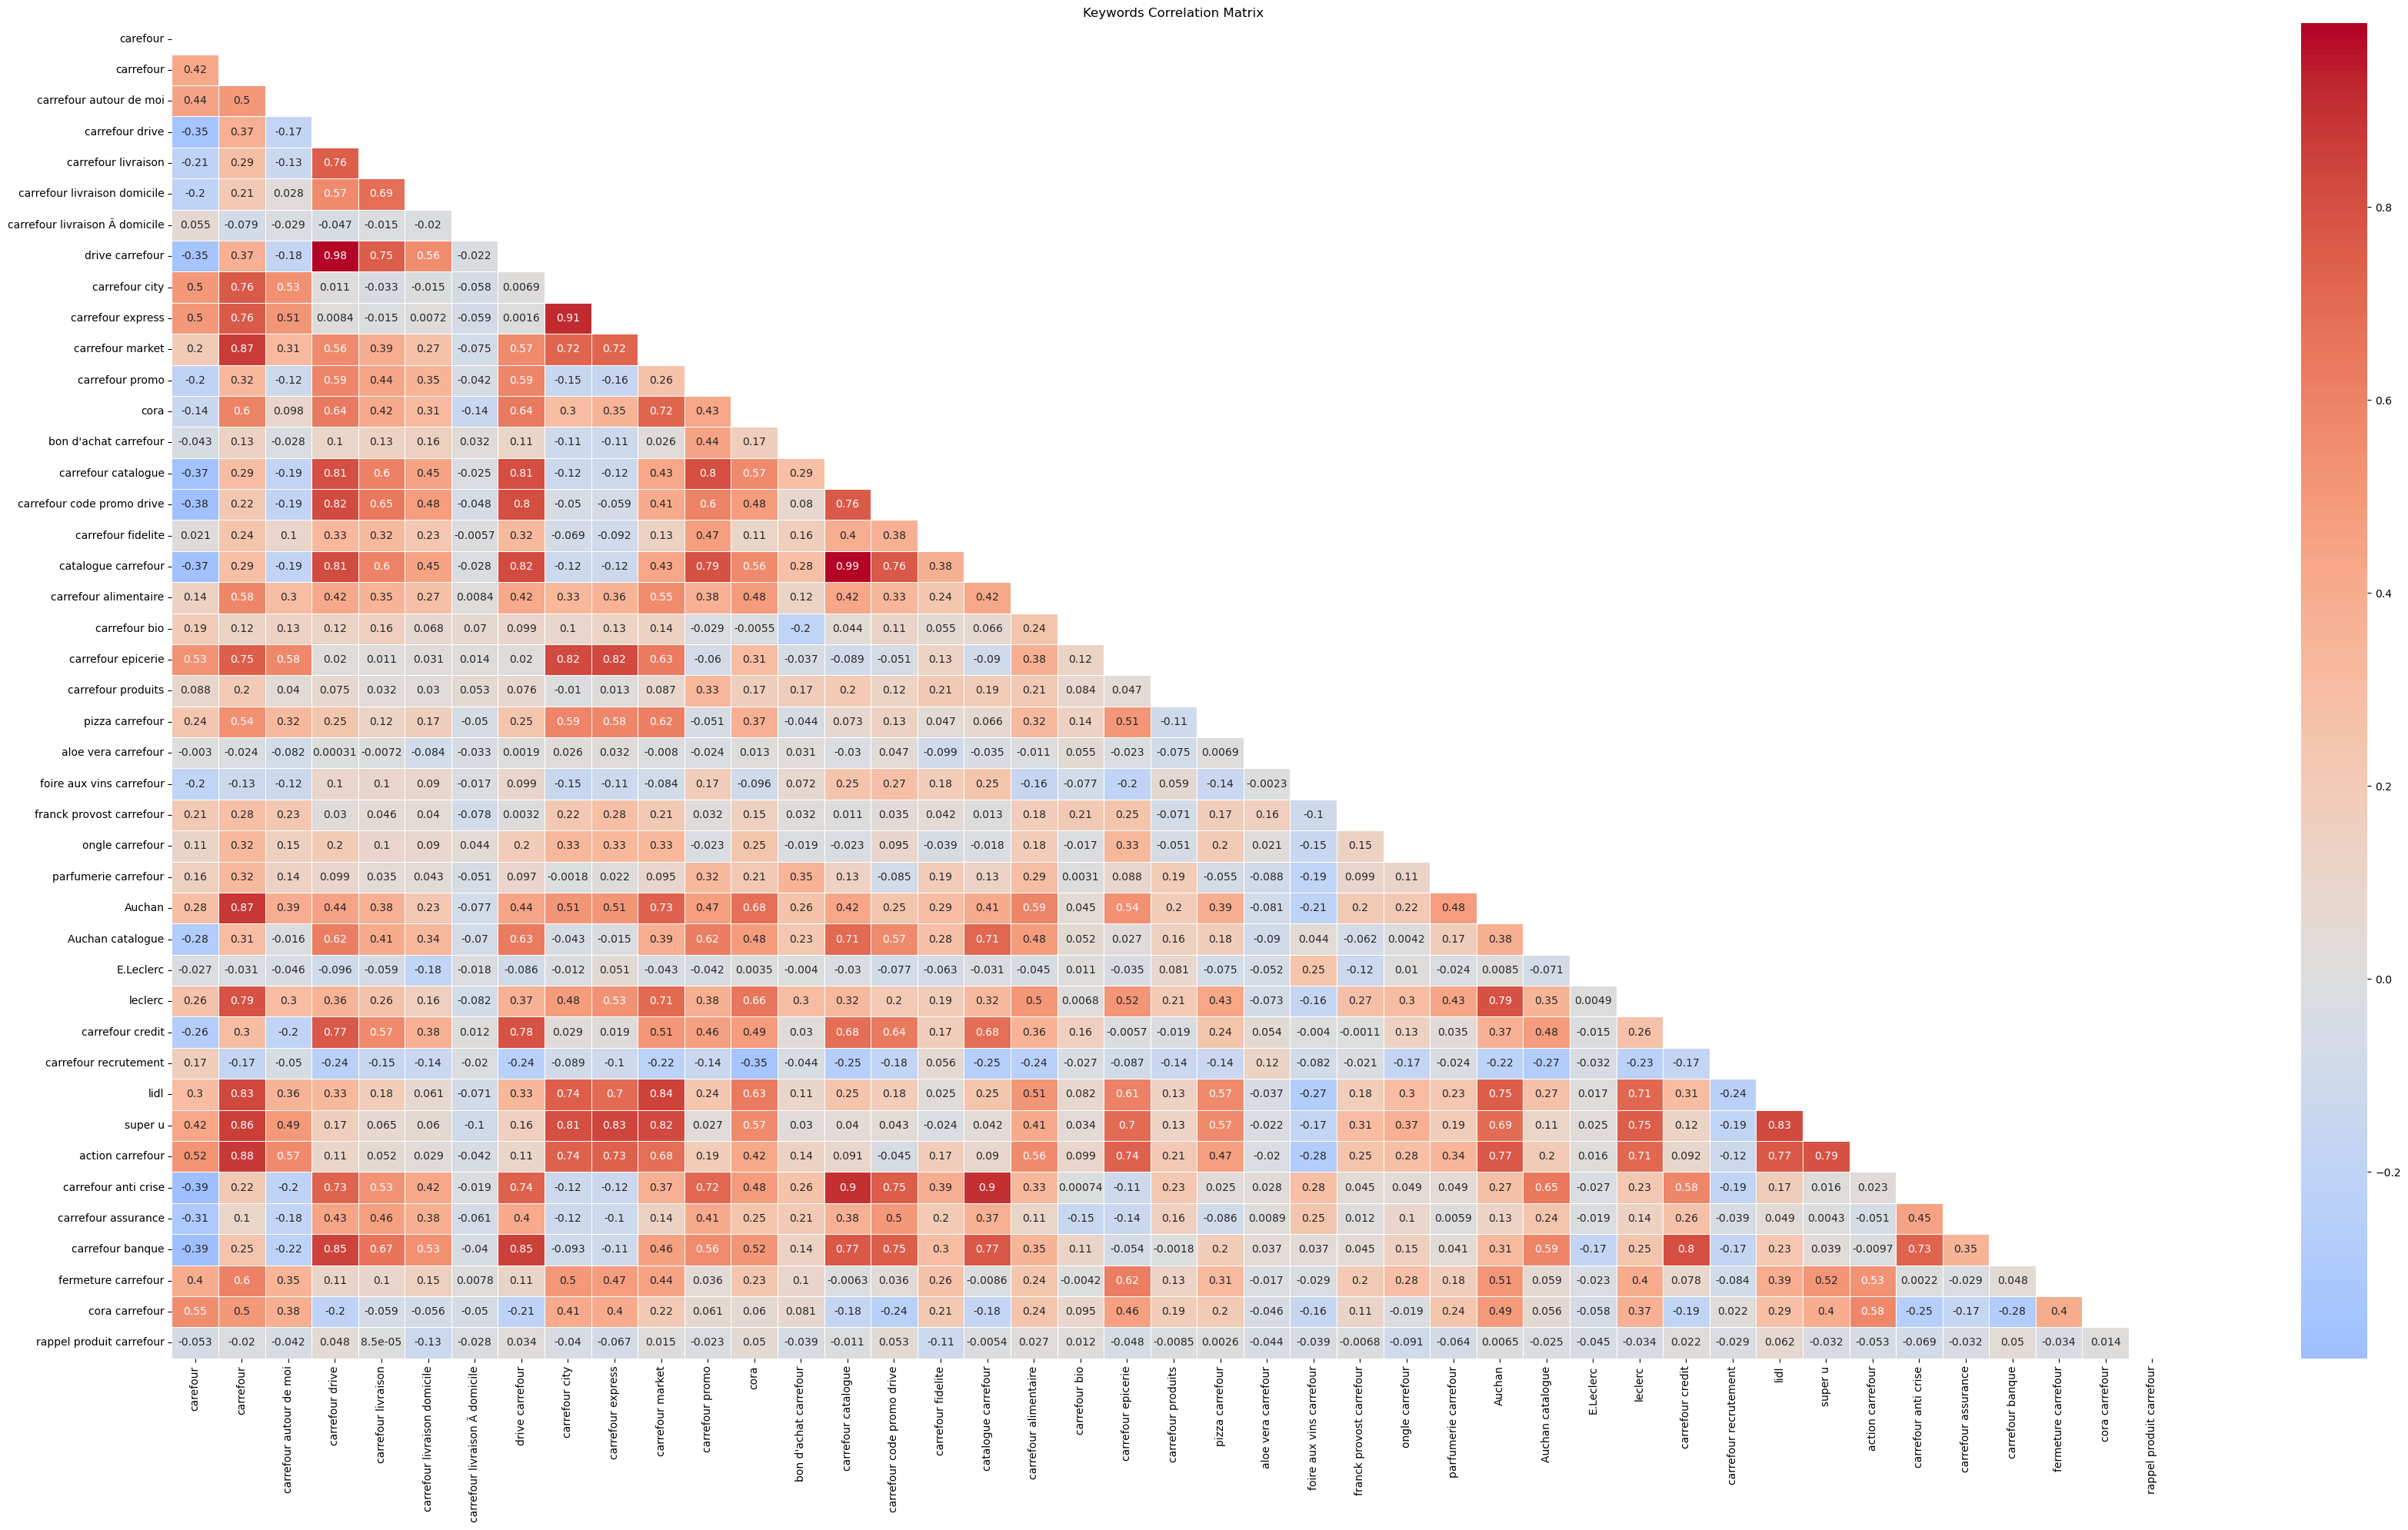

In [23]:
# Plot heatmap of correlation matrix for keyword search trends
corr = df_kw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(35, 20))
sns.heatmap(corr, 
            mask=mask, 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5, 
            annot=True)
plt.title("Keywords Correlation Matrix")
plt.tight_layout()

#save figure as png
plt.savefig('svi_correlation_matrix.png', bbox_inches='tight', dpi=300)

plt.show()

In [24]:
# Transform correlation matrix into list and categorise correlation strength
corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Keyword1', 'Keyword2', 'Correlation']

def categorize_corr(value):
    if value >= 0.8:
        return 'High Positive'
    elif value <= -0.8:
        return 'High Negative'
    elif value >= 0.4:
        return 'Average Positive'
    elif value <= -0.4:
        return 'Average Negative'
    elif value >= 0.0:
        return 'Low Positive'
    elif value > -0.4:
        return 'Low Negative'
    else:
        value
        return 'Negative'

corr_pairs['Category'] = corr_pairs['Correlation'].apply(categorize_corr)

##### HIGH CORRELATION PAIRS

In [25]:
# Display keyword pairs with high correlations
high_corr = corr_pairs[corr_pairs['Category'].isin(['High Positive', 'High Negative'])]
print(high_corr.to_string(index=False))

           Keyword1                   Keyword2  Correlation      Category
          carrefour           carrefour market     0.868893 High Positive
          carrefour                     Auchan     0.874106 High Positive
          carrefour                       lidl     0.831955 High Positive
          carrefour                    super u     0.860109 High Positive
          carrefour           action carrefour     0.876313 High Positive
    carrefour drive            drive carrefour     0.981436 High Positive
    carrefour drive        carrefour catalogue     0.807754 High Positive
    carrefour drive carrefour code promo drive     0.816569 High Positive
    carrefour drive        catalogue carrefour     0.814820 High Positive
    carrefour drive           carrefour banque     0.846021 High Positive
    drive carrefour        carrefour catalogue     0.810264 High Positive
    drive carrefour carrefour code promo drive     0.802074 High Positive
    drive carrefour        catalogue c

Highly correlated keywords are all positive indicating a strong linear positive correlation.

* Carrefour and its sub-brands/services show consistently high correlations, suggesting that interest in Carrefour as a brand is strongly tied to its different offerings.
* Consumers frequently search promotions or catalogues in conjunction with drive-related services.
* Strong correlation between Carrefour and competitors, suggesting that users often compare multiple grocery retailers in the same session or buying cycle.
* High correlation between localised formats, confirming the literature as of France's interest in urban and convenience-oriented store formats

##### AVERAGE CORRELATION PAIRS

Reflect moderately aligned but differentiated consumer behaviours.

In [26]:
# Display keyword pairs with average correlations
avg_corr = corr_pairs[corr_pairs['Category'].isin(['Average Positive', 'Average Negative'])]
print(avg_corr.to_string(index=False))

                    Keyword1                     Keyword2  Correlation         Category
                    carefour                    carrefour     0.420956 Average Positive
                    carefour      carrefour autour de moi     0.442474 Average Positive
                    carefour               carrefour city     0.499707 Average Positive
                    carefour            carrefour express     0.500020 Average Positive
                    carefour           carrefour epicerie     0.525883 Average Positive
                    carefour                      super u     0.424075 Average Positive
                    carefour             action carrefour     0.522155 Average Positive
                    carefour               cora carrefour     0.550883 Average Positive
                   carrefour      carrefour autour de moi     0.496390 Average Positive
                   carrefour               carrefour city     0.762156 Average Positive
                   carrefour    

##### LOW CORRELATION PAIRS

In [27]:
# Display keyword pairs with low correlations
low_corr = corr_pairs[corr_pairs['Category'].isin(['Low Positive', 'Low Negative'])]
print(low_corr.to_string(index=False))

                      Keyword1                       Keyword2  Correlation     Category
                      carefour                carrefour drive    -0.348986 Low Negative
                      carefour            carrefour livraison    -0.207524 Low Negative
                      carefour   carrefour livraison domicile    -0.201516 Low Negative
                      carefour carrefour livraison Ã domicile     0.055329 Low Positive
                      carefour                drive carrefour    -0.345700 Low Negative
                      carefour               carrefour market     0.196291 Low Positive
                      carefour                carrefour promo    -0.202750 Low Negative
                      carefour                           cora    -0.135878 Low Negative
                      carefour          bon d'achat carrefour    -0.042758 Low Negative
                      carefour            carrefour catalogue    -0.365542 Low Negative
                      carefour  

**Positive Low Correlations**
* Product-specific keywords (aloe vera, pizza, ongle carrefour) often exhibit isolated behaviours, hinting at niche shopping intent or product-specific campaigns.

**Negative Correlations**
* These pairs indicate weak or diverging search behaviour, which may suggest: niche interest, separate consumer journeys, misalignment in search intent or timing.
* `carefour` (misspelt) has several negative correlations (`carrefour drive` (-0.35), `carrefour promo` (-0.20), `carrefour catalogue` (-0.36)), suggesting noise or irrelevant intent behind this keyword.

##### Conclusions
Based on the descriptive analysis, count of zeros in the columns, and correlation matrix, we can state the following for our analysis:

* `carefour`: Highly noisy and negatively correlated with most Carrefour terms, it will be removed as it may not be relevant. 
* `carrefour livraison à domicile`: Sparse and episodic search behaviour, will be aggregated with `carrefour livraison domicile`.
* `aloe vera carrefour`: Niche product search, best to aggregate it with other FMCG keywords.
* `E.Leclerc`: inconsistent sample, best to remove as there is already the `lecerc` keyword fulfilling the same search intent.
* `carrefour recrutement`: Episodic search, while it possibly follows a seasonal recruitment pattern, it has too little data to provide insight fully.
* `rappel produit carrefour`: Event-driven; behaves independently from regular consumer patterns.

In [28]:
#drop desired keywords
df_svi = df_kw.drop(columns=["carefour", "E.Leclerc", "carrefour recrutement"])

In [29]:
# Check the dimensions of the DataFrame
df_svi.shape

(178, 40)

## Google Trends keywords aggregated

Based on search intent, keywords can be aggregated as follows:

> ⚠️ keywords marked as ~~keywords~~ are those dropped after the initial EDA

| Aggregate | Keywords | Justification |
|---|---|---|
| Brand | carrefour, carrefour autour de moi, ~~carrefour near me~~, ~~carfour~~, ~~carefour~~ | Serves as an anchor term to capture general brand interest and visibility. |
| Service and logistics | carrefour drive, drive carrefour, carrefour livraison, carrefour livraison domicile, carrefour livraison Ã domicile | Reflects consumer demand for fulfilment services such as click-and-collect and home delivery, indicating operational engagement. |
| Sub-brand | carrefour market, carrefour city, carrefour express, cora | Provides more granular insight into Carrefour’s diversified retail formats and regional presence. |
| Promo and engagement | carrefour promo, carrefour code promo drive, carrefour catalogue, catalogue carrefour, carrefour fidelite, bon d'achat carrefour | Captures interest in promotions, loyalty programs, and catalogues; key drivers of footfall and conversion in price-sensitive FMCG segments. |
| FMCG products | carrefour produits, carrefour alimentaire, carrefour epicerie, carrefour bio, pizza carrefour, foire aux vins carrefour, ongle carrefour, franck provost carrefour, parfumerie carrefour, aloe vera carrefour | Reflects consumer preferences for specific product categories; interest in organic and beauty items may indicate evolving lifestyle and sustainability trends. |
| Competitors | Auchan, Auchan catalogue, ~~E.Leclerc~~, leclerc, ~~IntermarchÃ©~~, lidl, super u  | Rising interest in competing retailers may signal market share shifts or influence investor sentiment regarding Carrefour. |
| Finance | ~~carrefour bourse~~, ~~carrefour recrutement~~, carrefour credit, carrefour assurance, action carrefour, carrefour banque, carrefour anti crise | Indicates public engagement with Carrefour’s financial operations, job market relevance, and economic resilience. |
| News  | fermeture carrefour, rappel produit carrefour, cora carrefour | Tracks external news-driven factors, including store closures and product recalls, which may impact consumer trust or financial outlook. |

In [30]:
#free up memory by deleting no longer used variables
del avg_corr, c, col_sum, columns_to_check, corr, corr_pairs, df_kw, dropped_cols, final_cols, high_corr, i, keyword, low_corr, missing, n_cols, n_keywords, n_rows, summary, zeros

In [31]:
#show preview keywords
df_agg.show(5)
df_agg.printSchema()

+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
|      date|Brand|Competitors|FMCG products|Finance|News|Promo and engagement|Service and logistics|Sub-brand|
+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
|26/12/2021|   93|        229|          231|    179|  82|                 201|                  209|      226|
|02/01/2022|   74|        179|          172|    184|  41|                 202|                  217|      160|
|09/01/2022|   62|        152|          161|    157|  36|                 184|                  183|      129|
|16/01/2022|   55|        140|          151|    149|  33|                 155|                  173|      124|
|23/01/2022|   52|        146|          144|    144|  31|                 146|                  160|      122|
+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
o

In [32]:
# Convert PySpark DataFrame to Pandas
df_agg = df_agg.toPandas()

In [33]:
# Ensure 'date' column is datetime and set it as the index
df_agg['date'] = pd.to_datetime(df_agg['date'], dayfirst=True)
df_agg.set_index('date', inplace=True)

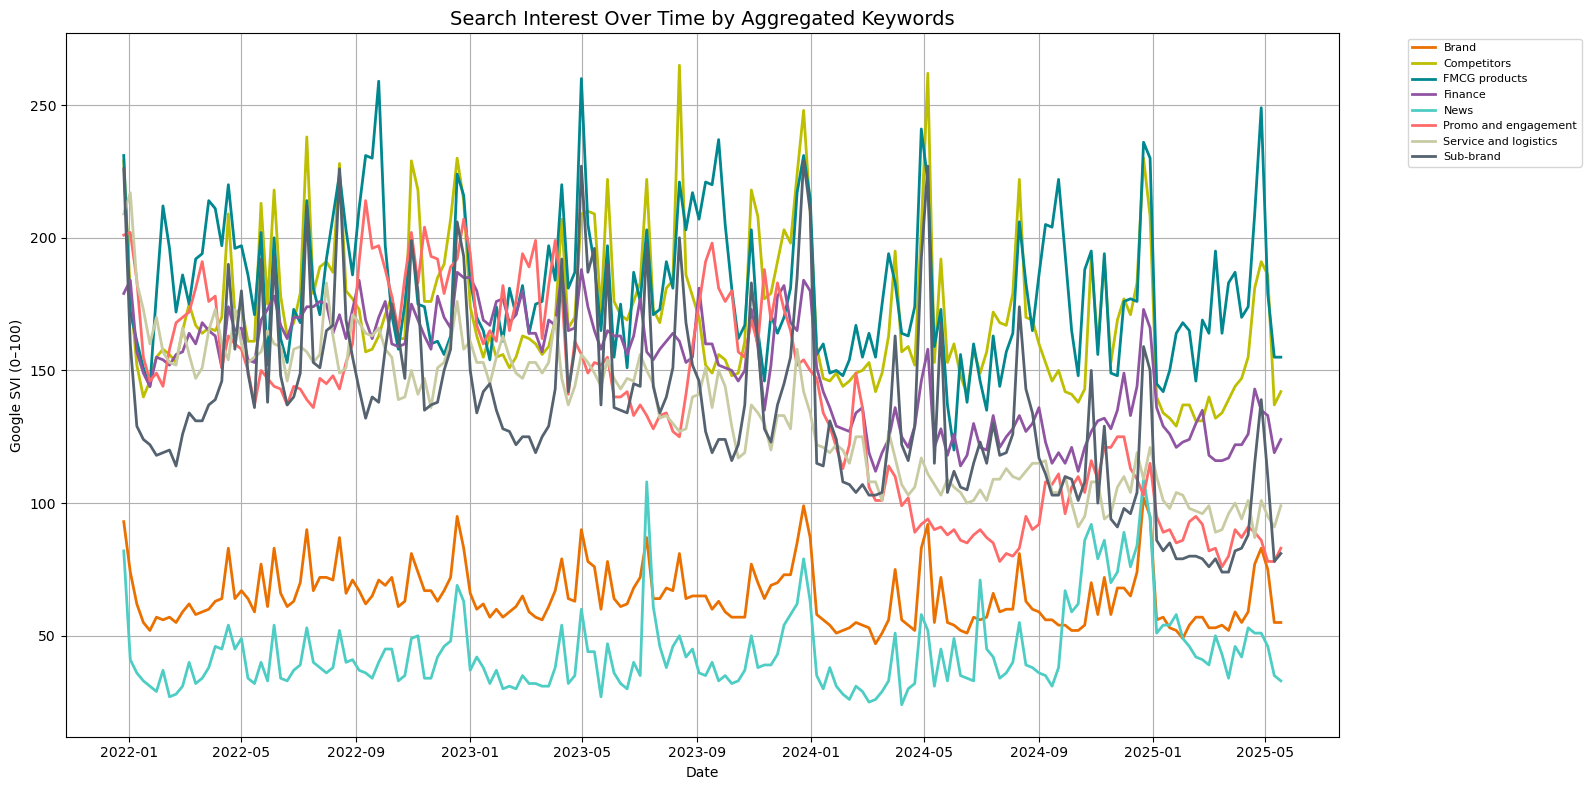

In [34]:
# Define custom color palette
colour = ["#EA7000","#BDBF00","#00878F","#9055A2","#4ECDC4","#FF6B6B","#C9CBA3","#556270"]   # set colour palette

# Plotting all keywords 
plt.figure(figsize=(16, 8))

for keyword, color in zip(df_agg.columns, colour):
    plt.plot(df_agg.index, df_agg[keyword], label=keyword, linewidth=2, color=color)

plt.title("Search Interest Over Time by Aggregated Keywords", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Google SVI (0–100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

The aggregation of the SVI data in the `carrefour_search_trends_aggregated.csv` was initially performed at the data collection stage in the following manner: 
- one column for each aggregated category (as defined in the table above);
- each row represents a time period with weekly frequency;
- each value is the sum of the SVI values for all keywords belonging to that category at that point in time.

However, this initial aggregation method is methodologically unsatisfactory. In Google Trends each keyword's SVI is scaled individually (where 0 represent the lowest relative search interest and 100 the peak relative interest within the time range selected), therefore, summing across keywords combines values on different scales. As such we risk overemphasising categories with more keywords and introduce bias if some keywords exhibit greater volatility than others.

To enhance the interpretability and methodological robustness of the analysis, alternative aggregation techniques should be considered:

| Aggregation Method   | Analysis   | 
|:---|:---|
| Simple mean | Assigns equal weight to all keywords, avoids keyword-count bias, and is easy to interpret. |
| Weighted mean | Offers higher accuracy if reliable weights (e.g., based on historical correlation or relevance) are available. |
| Z-score normalised mean | Standardises keyword volatility and expresses interest relative to each keyword’s historical mean. |
| Median | More robust to outliers and episodic spikes, especially useful with erratic or sparse search data. |
| Principal component aggregation (PCA) | Extracts the dominant shared pattern across keywords, ideal when a common driver is expected. |
| Maximum value (peak interest) | Highlights the most significant surge in attention per period, suitable for tracking event-driven spikes. |
| Frequency-based binary aggregation | Converts SVIs into binary indicators (e.g., 1 if above threshold), capturing the breadth of search interest per category. |

Using the mean as the aggregation method is likely the most appropriate option, as it mitigates the bias of differing keyword counts while also offering an intuitive measure of category-level search interest. However, to avoid weight bias, keywords with almost equal search intent will be aggregated separately first; these are:
* "carrefour drive", "drive carrefour"
* "carrefour livraison", "carrefour livraison domicile", "carrefour livraison Ã domicile"
* "carrefour promo", "carrefour code promo drive"
* "carrefour catalogue", "catalogue carrefour"
* "Auchan", "Auchan catalogue"

In [35]:
# Averaging specified keywords and creating new merged columns using df_kw_pd
df_svi["c_drive"] = df_svi[["carrefour drive", "drive carrefour"]].mean(axis=1)
df_svi["c_livraison"] = df_svi[["carrefour livraison", "carrefour livraison domicile", "carrefour livraison Ã domicile"]].mean(axis=1)
df_svi["promo"] = df_svi[["carrefour promo", "carrefour code promo drive"]].mean(axis=1)
df_svi["catalogue"] = df_svi[["carrefour catalogue", "catalogue carrefour"]].mean(axis=1)
df_svi["auchan"] = df_svi[["Auchan", "Auchan catalogue"]].mean(axis=1)

In [36]:
#dropping old keywords now merged
df_svi = df_svi.drop(columns=[
    "carrefour drive", "drive carrefour",
    "carrefour livraison", "carrefour livraison domicile", "carrefour livraison Ã domicile",
    "carrefour promo", "carrefour code promo drive",
    "carrefour catalogue", "catalogue carrefour",
    "Auchan", "Auchan catalogue"
])

In [37]:
# Check the dimensions of the DataFrame
df_svi.shape

(178, 34)

In [38]:
# Check the dimensions of the DataFrame
df_svi.columns 

Index(['carrefour', 'carrefour autour de moi', 'carrefour city',
       'carrefour express', 'carrefour market', 'cora',
       'bon d'achat carrefour', 'carrefour fidelite', 'carrefour alimentaire',
       'carrefour bio', 'carrefour epicerie', 'carrefour produits',
       'pizza carrefour', 'aloe vera carrefour', 'foire aux vins carrefour',
       'franck provost carrefour', 'ongle carrefour', 'parfumerie carrefour',
       'leclerc', 'carrefour credit', 'lidl', 'super u', 'action carrefour',
       'carrefour anti crise', 'carrefour assurance', 'carrefour banque',
       'fermeture carrefour', 'cora carrefour', 'rappel produit carrefour',
       'c_drive', 'c_livraison', 'promo', 'catalogue', 'auchan'],
      dtype='object')

In [39]:
df_svi_agg = df_svi.copy()

In [40]:
#aggregating variables based on category
df_svi_agg["brand"] = df_svi_agg[["carrefour", "carrefour autour de moi"]].mean(axis=1)
df_svi_agg["service"] = df_svi_agg[["c_drive", "c_livraison"]].mean(axis=1)
df_svi_agg["sub-brand"] = df_svi_agg[["carrefour market", "carrefour city", "carrefour express", "cora"]].mean(axis=1)
df_svi_agg["promo"] = df_svi_agg[["promo", "catalogue", "carrefour fidelite", "bon d'achat carrefour"]].mean(axis=1)
df_svi_agg["fmcg"] = df_svi_agg[["carrefour produits", "carrefour alimentaire", "carrefour epicerie", "carrefour bio", "pizza carrefour", "foire aux vins carrefour", "ongle carrefour", "franck provost carrefour", "parfumerie carrefour", "aloe vera carrefour"]].mean(axis=1)
df_svi_agg["competitors"] = df_svi_agg[["auchan", "leclerc", "lidl", "super u"]].mean(axis=1)
df_svi_agg["finance"] = df_svi_agg[["carrefour credit", "carrefour assurance", "action carrefour", "carrefour banque", "carrefour anti crise"]].mean(axis=1)
df_svi_agg["news"] = df_svi_agg[["fermeture carrefour", "rappel produit carrefour", "cora carrefour"]].mean(axis=1)

In [41]:
#dropping old keywords now merged
df_svi_agg = df_svi_agg.drop(columns=[
    "carrefour", "carrefour autour de moi", "carrefour city",
    "carrefour express", "carrefour market", "cora", "bon d'achat carrefour",
    "carrefour fidelite", "carrefour alimentaire", "carrefour bio", "carrefour epicerie", "carrefour produits",
    "pizza carrefour", "aloe vera carrefour", "foire aux vins carrefour",
    "franck provost carrefour", "ongle carrefour", "parfumerie carrefour",
    "leclerc", "carrefour credit", "lidl", "super u", "action carrefour",
    "carrefour anti crise", "carrefour assurance", "carrefour banque",
    "fermeture carrefour", "cora carrefour", "rappel produit carrefour",
    "c_drive", "c_livraison", "promo", "catalogue", "auchan"  # fixed here
])

In [42]:
# Check the dimensions of the DataFrame
df_svi_agg.shape

(178, 7)

In [43]:
# Check the dimensions of the DataFrame
df_svi_agg.columns 

Index(['brand', 'service', 'sub-brand', 'fmcg', 'competitors', 'finance',
       'news'],
      dtype='object')

### EDA Aggregated DataFrame df_agg_final

##### 1. Statistical Summary

In [44]:
# Generate summary statistics for aggregated SVI data
df_svi_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,178.0,32.205056,5.379531,23.500,28.000000,31.00,35.000000,50.500000
service,178.0,32.411517,6.431920,21.000,26.375000,33.25,37.458333,52.500000
sub-brand,178.0,33.943820,8.642193,18.500,28.750000,33.50,37.750000,57.250000
fmcg,178.0,18.134270,2.653173,12.000,16.300000,17.50,19.700000,26.000000
competitors,178.0,40.403090,6.369348,30.375,36.031250,39.25,42.968750,63.375000
finance,178.0,30.164045,4.294794,22.400,25.800000,31.30,33.600000,37.600000
news,178.0,14.717228,5.266823,8.000,11.333333,13.00,16.666667,36.333333


##### 2. Correlation Matrix 

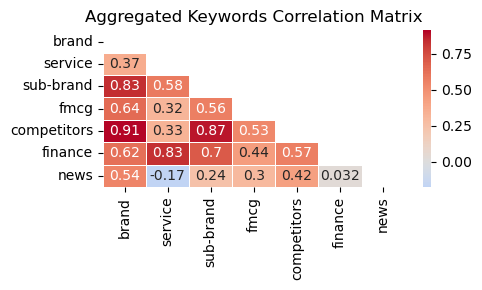

In [45]:
# Plot heatmap for correlations among aggregated keyword trends
corr = df_svi_agg.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(5, 3))
sns.heatmap(corr, 
            mask=mask, 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5, 
            annot=True)
plt.title("Aggregated Keywords Correlation Matrix")
plt.tight_layout()

#save figure as png
plt.savefig('svi_agg_corr_matrix.png', bbox_inches='tight', dpi=300)

plt.show()

##### 3. Boxplots

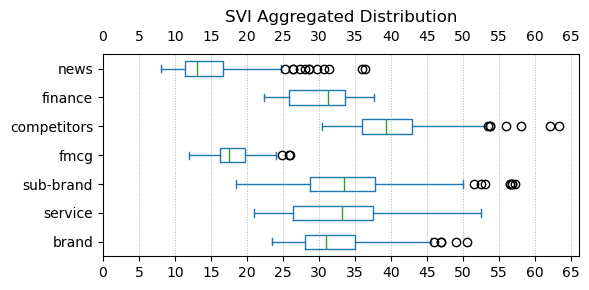

In [46]:
# Boxplot of aggregated keyword search volumes
df_svi_agg.plot(kind='box', vert=False, figsize=(6, 3), title='SVI Aggregated Distribution')
plt.tick_params(axis='x', which='both', labeltop=True)
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.xticks(np.arange(0, 70, 5))
plt.tight_layout()

#save figure as png
plt.savefig('svi_agg_distribution_boxplot.png', bbox_inches='tight', dpi=300)

plt.show()

##### 4. Time Series Trends

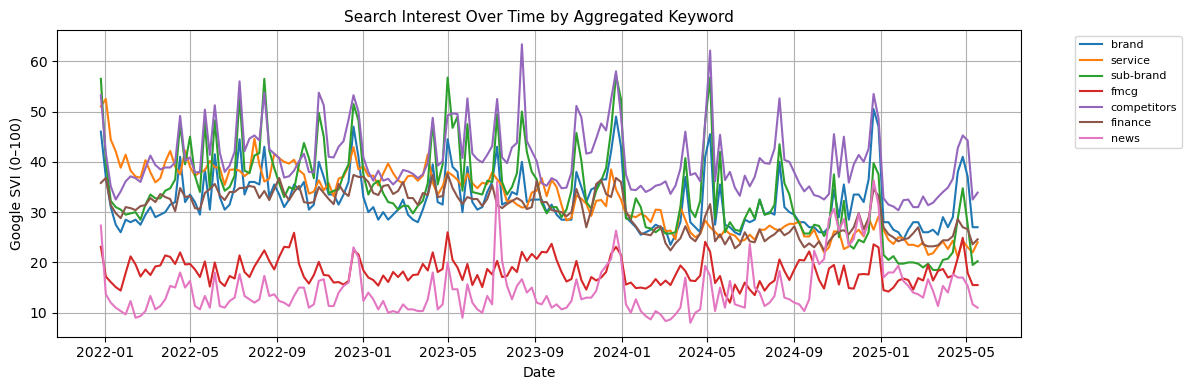

In [47]:
# Plotting all keywords in timeseries
plt.figure(figsize=(12, 4))

for idx, keyword in enumerate(df_svi_agg.columns):
    plt.plot(df_svi_agg.index, df_svi_agg[keyword], label=keyword)

plt.title("Search Interest Over Time by Aggregated Keyword", fontsize=11)
plt.xlabel("Date")
plt.ylabel("Google SVI (0–100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.grid(True)

#save figure as png
plt.savefig('svi_agg_keyword_trends.png', bbox_inches='tight', dpi=300)

plt.show()

# Carrefour France stock data
This data wascollected att daily and weekly frequenciey.

In [48]:
#read CSV using Spark
df_fin = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_stock_data.csv', header=True, inferSchema=True)
df_wfin = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_stock_weekly.csv', header=True, inferSchema=True)

#### Daily stocks

In [49]:
#show preview daily stocks
df_fin.show(5)
df_fin.printSchema()

+-------------------+------------------+------------------+------------------+------------------+-------+---------+------------+
|               Date|              Open|              High|               Low|             Close| Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+-------+---------+------------+
|2022-01-03 00:00:00|14.412475049746167| 14.45706742372177|14.251939781689956|14.376801490783691|1539521|      0.0|         0.0|
|2022-01-04 00:00:00|14.452608499187328|14.639900207519531|14.381259681986961|14.639900207519531|1921444|      0.0|         0.0|
|2022-01-05 00:00:00|14.622063598058403|15.607569735983143|14.586388336424337|15.384604454040527|7593876|      0.0|         0.0|
|2022-01-06 00:00:00| 15.78594174663718|16.490511113047717|15.607568850763876|16.352272033691406|9738108|      0.0|         0.0|
|2022-01-07 00:00:00| 16.31213981324636|16.624289827380004|16.160523363057166| 16.37010955810547|

#### Weekly stocks

In [50]:
#show preview stocks
df_wfin.show(5)
df_wfin.printSchema()

+-------------------+------------------+------------------+------------------+------------------+--------+---------+------------+
|               Date|              Open|              High|               Low|             Close|  Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+--------+---------+------------+
|2022-01-03 00:00:00|  14.4124747784588|16.624289827380004| 14.25193951342436| 16.37010955810547|25331076|      0.0|         0.0|
|2022-01-10 00:00:00| 16.33889431434613| 16.45929576133611| 15.57189325993142| 15.75472640991211|18968388|      0.0|         0.0|
|2022-01-17 00:00:00|15.821616593224354|16.089175958816803|15.384604833955846|15.661081314086914|16451615|      0.0|         0.0|
|2022-01-24 00:00:00|15.696755275388963|16.098091738872853|15.215149477900288|  15.9375581741333|19400666|      0.0|         0.0|
|2022-01-31 00:00:00| 15.81269534575529|15.843910345110322|14.604224081896566|14.956509590

##### Convert PySpark DataFrame to Pandas to analyse 

In [51]:
# Convert yFinance stock data to pandas
df_stock = df_wfin.toPandas()

In [52]:
# Check the dimensions of the DataFrame
df_stock.shape

(177, 8)

### The time issue. 

Upon reviewing the collected datasets, a discrepancy in date labelling was identified between the weekly stock data from `yfinance` and the Google Trends keyword data. To facilitate data comparison and accurate time-series modelling, all datasets must share a standard, synchronised timeframe.

1. *Stock Market Data*

The weekly stock data from `yfinance` uses Monday as the label for each weekly observation. However, each row in the dataset represents the week ending Friday, but is indexed by the preceding Monday.

2. *Google Trends Data*

Google Trends aggregates search interest weekly, with each week's data point labelled by Sunday, the end of the search week.


This results in a misalignment between:
* Stock closing prices (on Friday, labelled as Monday),
* Search volume data (ending Sunday).

The solution to align both datasets:
* Google Trends dates will be shifted −2 days (from Sunday → Friday) to represent the end of the same week as the stock market.
* Stock data dates will be shifted +4 days (from Monday → Friday) to reflect the actual trading day.

This ensures that both data sources are indexed by the same Friday date, making them directly comparable for all subsequent analysis.

##### Adjust Google Trends dates (from Sunday to Friday)

In [53]:
# Align weekly indexes of Google Trends
df_svi.index = df_svi.index - pd.Timedelta(days=2)
# Align weekly indexes of Aggregated Google Trends
df_svi_agg.index = df_svi_agg.index - pd.Timedelta(days=2)

##### Adjust Stock Data dates (from Monday to Friday)

In [54]:
# Align weekly indexes of yFinance
df_stock['Date'] = pd.to_datetime(df_stock['Date']) + pd.Timedelta(days=4)

In [55]:
#set date as index
df_stock.set_index('Date', inplace=True)

In [56]:
# Print date ranges of both datasets to ensure alignment
print('Google Trends')
print(df_svi.index.min(), df_svi.index.max())
print('Aggregated Google Trends')
print(df_svi_agg.index.min(), df_svi_agg.index.max())
print('yFinance')
print(df_stock.index.min(), df_stock.index.max())

Google Trends
2021-12-24 00:00:00 2025-05-16 00:00:00
Aggregated Google Trends
2021-12-24 00:00:00 2025-05-16 00:00:00
yFinance
2022-01-07 00:00:00 2025-05-23 00:00:00


There is a date range difference between the two datasets; the `df_svi` and `df_svi_agg` start 2 weeks earlier and finish one week earlier than `df_stock`.

In [57]:
# Drop the first two weeks from Google Trends
df_svi = df_svi.iloc[2:]

# Drop the first two weeks from Aggregated Google Trends
df_svi_agg = df_svi_agg.iloc[2:]

# Drop the last week from stock data
df_stock = df_stock.iloc[:-1]

In [58]:
# Print date ranges of both datasets to ensure alignment
print('Google Trends')
print(df_svi.index.min(), df_svi.index.max())
print('Aggregated Google Trends')
print(df_svi_agg.index.min(), df_svi_agg.index.max())
print('yFinance')
print(df_stock.index.min(), df_stock.index.max())

Google Trends
2022-01-07 00:00:00 2025-05-16 00:00:00
Aggregated Google Trends
2022-01-07 00:00:00 2025-05-16 00:00:00
yFinance
2022-01-07 00:00:00 2025-05-16 00:00:00


Now the date has been trimmed to match for both dataset and it is ready to join.

In [59]:
# Get structure of yFinance dataset
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2022-01-07 to 2025-05-16
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          176 non-null    float64
 1   High          176 non-null    float64
 2   Low           176 non-null    float64
 3   Close         176 non-null    float64
 4   Volume        176 non-null    int32  
 5   Dividends     176 non-null    float64
 6   Stock Splits  176 non-null    float64
dtypes: float64(6), int32(1)
memory usage: 10.3 KB


For the aims and objectives set in the methodology, we will only retain the adjusted closing price from the stock market dataframe.

**Why?**
The adjusted closing price reflects the stock’s final trading price after accounting for dividends, splits, and other corporate actions. It provides the most accurate picture of a stock’s actual performance over time, it is especially good for:
* Time-series analysis
* Log-return calculations
* Correlation with external signals (e.g., SVIs)

In [60]:
# Keep only the 'Close' column
df_stock = df_stock[['Close']].copy()

# Renaming column for clarity when merging later
df_stock.rename(columns={'Close': 'Carrefour_Close'}, inplace=True)

df_stock.head(5)

,Carrefour_Close
Date,
2022-01-07,16.370110
2022-01-14,15.754726
2022-01-21,15.661081
2022-01-28,15.937558
2022-02-04,14.956510


**Missing Values Analysis**

Check how much missing and flat data there is.

In [61]:
# Check for any columns with missing values
missing = df_stock.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("Columns with missing values:")
    print(missing)
else:
    print("No missing values found.")


No missing values found.


In [62]:
# Check how many zero values exist per column
zeros = (df_stock == 0).sum()
zeros = zeros[zeros > 0]

if not zeros.empty:
    print("Number of zeros in columns:")
    print(zeros)
else:
    print("No columns with zeros values found.")


No columns with zeros values found.


##### 1. Close price over time

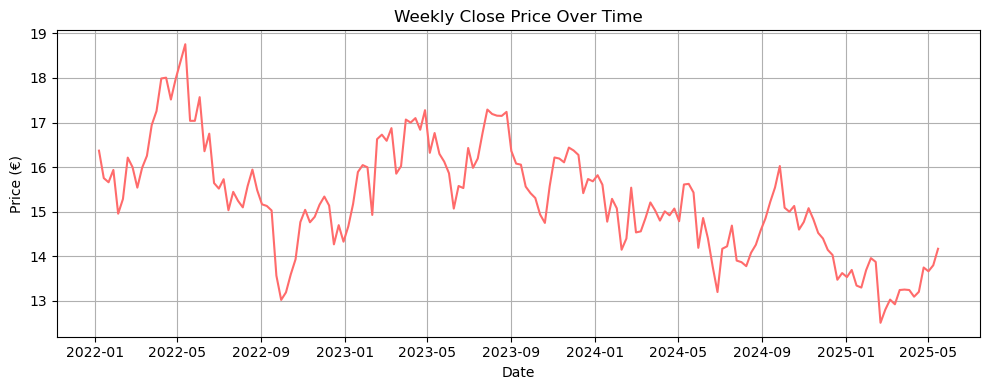

In [63]:
# Plot closing price over time
plt.figure(figsize=(10, 4))
plt.plot(df_stock.index, df_stock['Carrefour_Close'], label='Close Price', color='#FF6B6B')
plt.title("Weekly Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (€)")
plt.grid(True)
plt.tight_layout()

#save figure as png
plt.savefig('stock_price_close.png', bbox_inches='tight', dpi=300)

plt.show()

##### 2. Rolling mean

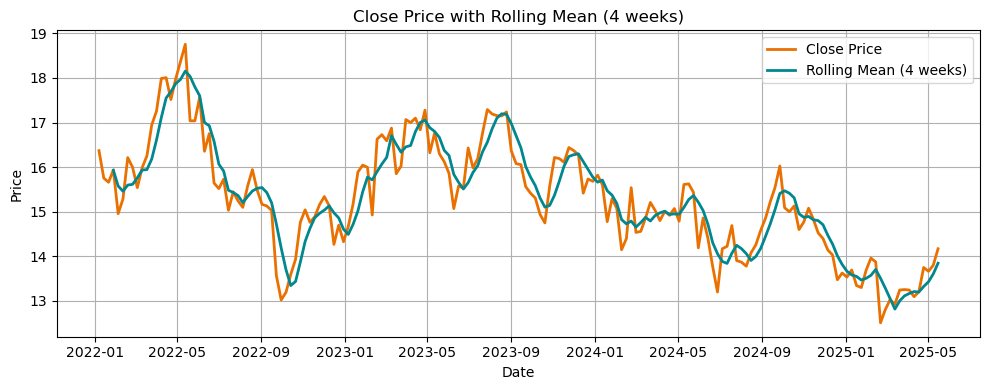

In [64]:
# Plot rolling mean and std deviation of stock price
df_stock['rolling_mean'] = df_stock['Carrefour_Close'].rolling(window=4).mean()
df_stock['rolling_std'] = df_stock['Carrefour_Close'].rolling(window=4).std()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_stock.index, df_stock['Carrefour_Close'], label='Close Price', color='#EA7000', linewidth=2)
plt.plot(df_stock.index, df_stock['rolling_mean'], label='Rolling Mean (4 weeks)', color='#00878F', linewidth=2)
plt.title('Close Price with Rolling Mean (4 weeks)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

#save figure as png
plt.savefig('stock_close_price_rolling_mean.png', bbox_inches='tight', dpi=300)

plt.show()

# Merged Datasets: SVIs and Price Close Data.

Analysing individual keywords (rather than aggregated categories) can reveal granular signals that might be averaged out or lost in grouped data.

### Merging Datasets: df_merged1

In [65]:
df_merged1 = df_svi.join(df_stock, how='inner')

In [66]:
df_merged1.head()

,carrefour,carrefour autour de moi,carrefour city,carrefour express,carrefour market,cora,bon d'achat carrefour,carrefour fidelite,carrefour alimentaire,carrefour bio,...,cora carrefour,rappel produit carrefour,c_drive,c_livraison,promo,catalogue,auchan,Carrefour_Close,rolling_mean,rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2022-01-07,62,0,17,5,48,59,0,3,28,61,...,31,0,83.5,5.333333,5.5,85.0,11.5,16.370110,NaN,NaN
2022-01-14,55,0,15,5,41,63,1,2,18,58,...,27,3,79.5,4.666667,5.0,71.0,10.0,15.754726,NaN,NaN
2022-01-21,52,0,17,5,42,58,0,3,18,59,...,26,0,73.0,4.666667,5.5,66.0,9.5,15.661081,NaN,NaN
2022-01-28,57,0,17,5,45,51,1,3,17,57,...,26,0,78.5,4.333333,5.5,67.0,10.5,15.937558,15.930869,0.314531
2022-02-04,56,0,17,5,45,52,0,3,26,55,...,32,2,72.5,4.000000,5.5,65.0,9.5,14.956510,15.577469,0.429599


In [67]:
df_merged1 = df_merged1.drop(columns=[ "rolling_mean", "rolling_std"])

In [68]:
df_merged1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2022-01-07 to 2025-05-16
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   carrefour                 176 non-null    int32  
 1   carrefour autour de moi   176 non-null    int32  
 2   carrefour city            176 non-null    int32  
 3   carrefour express         176 non-null    int32  
 4   carrefour market          176 non-null    int32  
 5   cora                      176 non-null    int32  
 6   bon d'achat carrefour     176 non-null    int32  
 7   carrefour fidelite        176 non-null    int32  
 8   carrefour alimentaire     176 non-null    int32  
 9   carrefour bio             176 non-null    int32  
 10  carrefour epicerie        176 non-null    int32  
 11  carrefour produits        176 non-null    int32  
 12  pizza carrefour           176 non-null    int32  
 13  aloe vera carrefour       176 non-null    int3

###  Correlation Before Stationarity Tests

In [69]:
# Pearson correlation matrix
pearson = df_merged1.corr(method='pearson')['Carrefour_Close'].drop('Carrefour_Close')
print("Pearson Correlations:")
print(pearson.sort_values(ascending=False))

Pearson Correlations:
c_drive                     0.602615
carrefour banque            0.513428
cora                        0.510547
catalogue                   0.505653
carrefour anti crise        0.472721
promo                       0.462629
carrefour credit            0.438171
carrefour market            0.414801
carrefour alimentaire       0.315956
lidl                        0.308593
leclerc                     0.286283
c_livraison                 0.275255
pizza carrefour             0.256202
auchan                      0.239071
carrefour assurance         0.204037
carrefour                   0.193228
super u                     0.154605
carrefour produits          0.140987
rappel produit carrefour    0.137112
ongle carrefour             0.105943
action carrefour            0.098168
carrefour bio               0.092550
carrefour fidelite          0.053472
carrefour express           0.038527
carrefour city              0.034387
aloe vera carrefour         0.032719
bon d'achat carr

In [70]:
# Spearman correlation matrix
spearman = df_merged1.corr(method='spearman')['Carrefour_Close'].drop('Carrefour_Close')
print("\nSpearman Correlations:")
print(spearman.sort_values(ascending=False))


Spearman Correlations:
c_drive                     0.591403
carrefour banque            0.521827
catalogue                   0.516311
carrefour anti crise        0.494914
promo                       0.494133
cora                        0.480566
carrefour market            0.477399
carrefour credit            0.438473
leclerc                     0.353922
lidl                        0.348550
auchan                      0.322941
c_livraison                 0.317377
carrefour alimentaire       0.316623
carrefour assurance         0.315055
pizza carrefour             0.292107
carrefour                   0.288308
super u                     0.217978
rappel produit carrefour    0.185000
action carrefour            0.170016
carrefour fidelite          0.157799
carrefour produits          0.121989
carrefour bio               0.093845
ongle carrefour             0.090550
carrefour epicerie          0.048736
bon d'achat carrefour       0.047472
foire aux vins carrefour    0.038102
carrefour city

**Strongest positive correlations**

These correlations (all > 0.45) indicate real-time or slightly lagged relevance between consumer search behaviours and Carrefour’s market performance.

| Keyword | Pearson | Spearman | Interpretation |
| ------- | ------- | -------- | -------------- |
| `c_drive`              | 0.603   | 0.591    | **Highest correlation** — strong link between online drive-related searches and stock price. This likely reflects service usage and & operational scale. |
| `carrefour banque`     | 0.513   | 0.522    | Financial arm interest possibly signals **investor awareness or trust**   |
| `catalogue`            | 0.506   | 0.516    | Regularly viewed catalogues may tie to promotional periods that affect revenue |
| `carrefour anti crise` | 0.473   | 0.495    | Interest in discount initiatives may align with **price-sensitive consumers** and operational adaptatability     |
| `promo`                | 0.463   | 0.494    | Promo searches likely peak during events that boost short-term sales, aligning with financial performance |
| `cora`                 | 0.511   | 0.481    | Competitor interest could reflect sector-wide consumer engagement or **comparative brand searches**      |l of risk, not growth

**Moderate to Weak Correlations (Still Informative)**

Keywords like `carrefour market`, `carrefour credit`, and `leclerc` show a Pearson/Spearman ~0.3–0.45 → mild alignment, possibly driven by product lines or regional interests.

General brand terms like `carrefour`, `lidl`, `auchan` fall below 0.3, which suggests background noise or baseline interest with no strong predictive power.

**Near-Zero or Negative Correlations**

| Keyword  | Pearson | Interpretation  |
| ---- | --- | --- |
| `carrefour express`, `epicerie`, `parfumerie   | \~0     | These keywords are **niche, location-specific, or low-volume** — little link to broader financial performance    |
| `fermeture carrefour`, `autour de moi`, `cora carrefour` | < -0.1  | These likely reflect **negative sentiment**, local store closures, or competitive attrition. Can be **signal of risk**, not growth  |


###  Stationarity Tests

Stationarity tests ensure that:

1. The input features (search trends) are stable and predictable over time.
2. The models (e.g., correlation or regression) are not falsely attributing relationships based on trending behaviour or structural changes in data.

To robustly assess stationarity and cross-validate findings, both the Augmented Dickey-Fuller (ADF) and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests will be carried out. Assessing simultaneously if the series is stationary (ADF) and is not stationary (KPSS).

In [71]:
# Apply ADF test
def adf_test(series):
    try:
        result = adfuller(series.dropna(), autolag='AIC')
        return result[1]  # p-value
    except:
        return None

In [72]:
# Apply KPSS test
def kpss_test(series):
    try:
        result = kpss(series.dropna(), regression='c', nlags='auto')
        return result[1]  # p-value
    except:
        return None
        

In [73]:
# Create a summary DataFrame
stationarity_summary = pd.DataFrame(columns=["ADF_pvalue", "KPSS_pvalue", "ADF_Stationary", "KPSS_Stationary"])

In [74]:
# Loop through each column in the DataFrame
for col in df_merged1.columns:
    adf_p = adf_test(df_merged1[col])
    kpss_p = kpss_test(df_merged1[col])
    
    stationarity_summary.loc[col] = [
        adf_p,
        kpss_p,
        "Yes" if adf_p is not None and adf_p < 0.05 else "No", #is it stationary? Stationary (p < 0.05) 
        "Yes" if kpss_p is not None and kpss_p > 0.05 else "No" #is it stationary? Stationary (p > 0.05)
    ]

C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic i

> **NOTE**: KPSS warnings indicate test statistics outside the tabulated p-value range.
> - If the returned p-value = 0.01 → actual p-value < 0.01 → strong evidence against stationarity.
> - If the returned p-value = 0.1  → actual p-value > 0.1  → weak evidence against stationarity.
>
> These bounds are used conservatively to classify series as stationary or not.

In [75]:
# Display results
stationarity_summary

,ADF_pvalue,KPSS_pvalue,ADF_Stationary,KPSS_Stationary
carrefour,7.382216e-11,0.066901,Yes,Yes
carrefour autour de moi,1.553901e-13,0.010000,Yes,No
carrefour city,6.829166e-14,0.100000,Yes,Yes
carrefour express,2.005387e-13,0.100000,Yes,Yes
carrefour market,1.391110e-01,0.010000,No,No
cora,4.079767e-01,0.010000,No,No
bon d'achat carrefour,1.309592e-05,0.100000,Yes,Yes
carrefour fidelite,3.326909e-08,0.100000,Yes,Yes
carrefour alimentaire,7.974931e-15,0.010000,Yes,No
carrefour bio,7.356709e-08,0.100000,Yes,Yes


**Which keywords are stationary?**

`carrefour`, `carrefour city`, `carrefour express`, `bon d'achat carrefour`, `carrefour fidelite`, `carrefour bio`, `carrefour epicerie`, `carrefour produits`, `aloe vera carrefour`, `foire aux vins carrefour`, `franck provost carrefour`, `ongle carrefour`, `parfumerie carrefour`, `super u`, `action carrefour`, `fermeture carrefour`, `rappel produit carrefour`.

**Which keywords are non-stationary?**

`carrefour market`, `cora`, `carrefour credit`, `carrefour anti crise`, `carrefour assurance`, `carrefour banque`, `c_drive`, `c_livraison`, `promo`, `catalogue`, **`Carrefour_Close`**.

**Inconclusive tests**

`carrefour autour de moi`, `carrefour alimentaire`, `pizza carrefour`, `leclerc`, `lidl`, `cora carrefour`, `auchan`._Close	1.344312e-01	0.010000	No	No
_Close	1.344312e-01	0.010000	No	No
_Close	1.344312e-01	0.010000	No	No


#### Assessing inconclusive tests

##### Visual Inspection

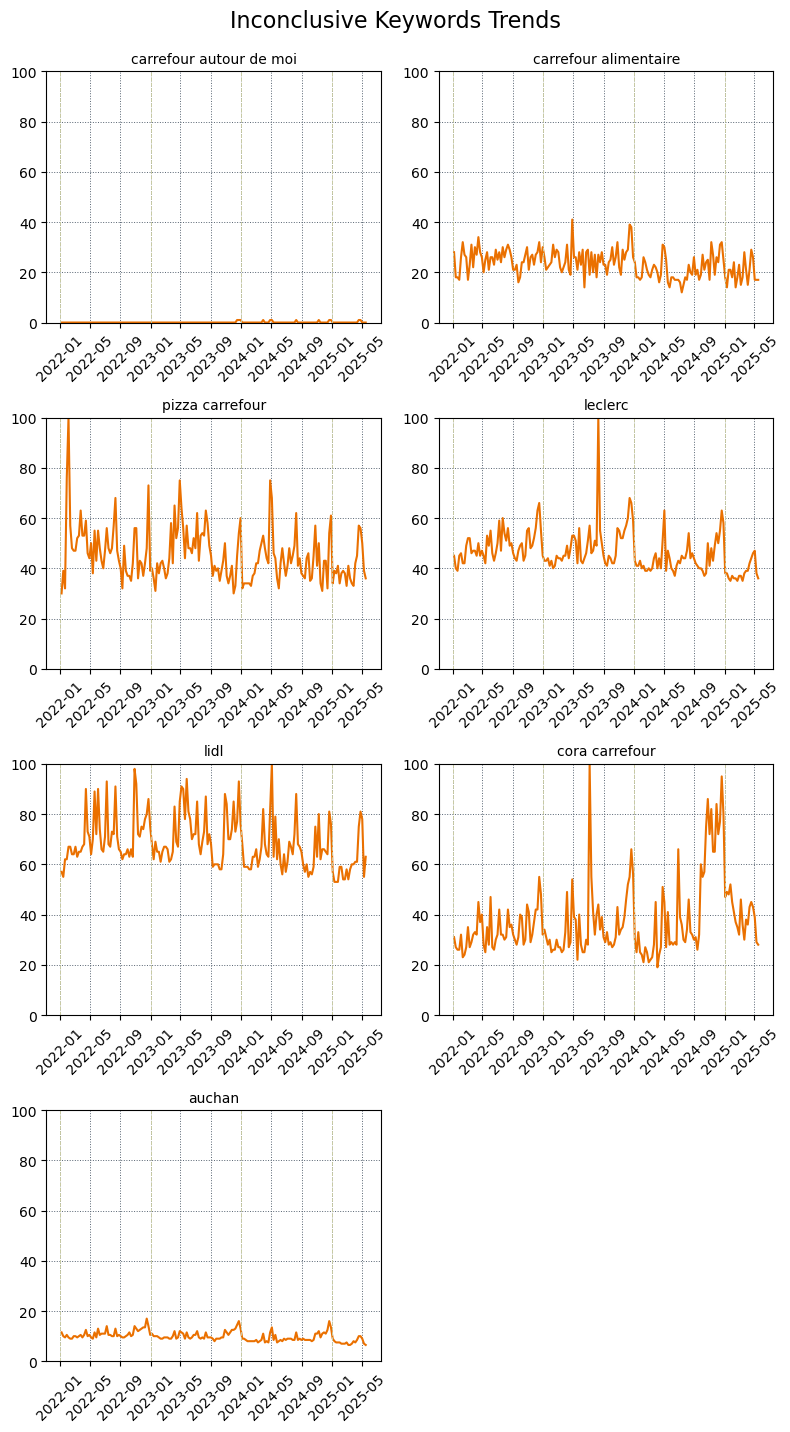

In [76]:
#plot inconclusive tests
#`carrefour autour de moi`, `carrefour alimentaire`, `pizza carrefour`, `leclerc`, `lidl`, `cora carrefour`, `auchan`.

#list of inconclusive keywords
inconclusive = ["carrefour autour de moi", "carrefour alimentaire", "pizza carrefour", "leclerc", "lidl", "cora carrefour", "auchan"]

n_cols = 2
n_rows = int(np.ceil(len(inconclusive) / n_cols))

plt.figure(figsize=(8, 14))

for i, keyword in enumerate(inconclusive):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(df_merged1.index, df_merged1[keyword], color='#EA7000')
    for year in range(2022, 2026):
        plt.axvline(pd.to_datetime(f"{year}-01-01"), color='#C9CBA3', linestyle='--', linewidth=0.7)
    plt.grid(True, which='both', axis='both', linestyle=':', linewidth=0.7, color='#556270')
    plt.title(keyword, fontsize=10)
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("Inconclusive Keywords Trends", fontsize=16, y=1.02)

#save figure as PNG
plt.savefig('inconclusive_trends.png', bbox_inches='tight', dpi=300)

plt.show()

Visual inspection of the inconclusive variables reveals a range of behaviours:
- `carrefour autour de moi` has near-zero values for most of the period, with searches only starting around the end of 2023.
- `carrefour alimentaire` has only mild variance shifts, but the mean is stable mainly
- `pizza carrefour` around January 2022 showcases high volatility, but then it stabilises
- `leclerc` shows some seasonality with peaks around September each year and seems to be weakly non-stationary
- `lidl` has seasonal repetition and seems to be weakly non-stationary
- `cora carrefour` seems to have some structural breaks in mid-series
- `auchan` mild seasonality around September

However to confirm this a different stationary test will be carried out.

##### Try the Phillips-Perron test

In [77]:
from arch.unitroot import PhillipsPerron

In [78]:
def pp_test(series):
    try:
        result = PhillipsPerron(series.dropna())
        return result.pvalue, result.stat
    except:
        return None, None

In [79]:
# Create a new summary DataFrame
pp_results = pd.DataFrame(columns=["PP_pvalue", "PP_stat", "PP_Stationary"])

In [80]:
# Apply to inconclusive series
inconclusive_cols = [
    'carrefour autour de moi', 'carrefour alimentaire', 'pizza carrefour',
    'leclerc', 'lidl', 'cora carrefour', 'auchan'
]

for col in inconclusive_cols:
    p_val, stat = pp_test(df_merged1[col])
    pp_results.loc[col] = [
        p_val,
        stat,
        "Yes" if p_val is not None and p_val < 0.05 else "No"
    ]

In [81]:
# Display result
pp_results

,PP_pvalue,PP_stat,PP_Stationary
carrefour autour de moi,1.323224e-13,-8.489757,Yes
carrefour alimentaire,1.128842e-17,-10.089985,Yes
pizza carrefour,1.527580e-13,-8.465375,Yes
leclerc,2.092272e-10,-7.222613,Yes
lidl,5.304354e-12,-7.860362,Yes
cora carrefour,1.648152e-08,-6.436466,Yes
auchan,1.885263e-07,-5.976169,Yes


Despite earlier ambiguity (e.g., KPSS at boundary values or visual uncertainty), the PP test rejects the null hypothesis of non-stationarity for each one, with extremely low p-values and strongly negative test statistics.


#### Transformation of non-stationary data

> !!! Before proceeding with the Correlation, Lagged and Time series analysis we need to transform both predictors (SVI keywords) and the outcome variable `Carrefour_Close` to make them stationary; an assumption of the models we will use later. 

##### Non-stationary keywords:
`carrefour market`, `cora`, `carrefour credit`, `carrefour anti crise`, `carrefour assurance`, `carrefour banque`, `c_drive`, `c_livraison`, `promo`, `catalogue`, `Carrefour_Close`.

**First-Order Differencing**

In [82]:
#create a non-stationary list
non_stat_cols = [
    'carrefour market', 'cora', 'carrefour credit', 'carrefour anti crise',
    'carrefour assurance', 'carrefour banque', 'c_drive', 'c_livraison',
    'promo', 'catalogue', 'Carrefour_Close'
]

#Apply First-Order Differencing
df_diff = df_merged1[non_stat_cols].diff().dropna()


In [83]:
#Drop original non-stationary columns from the original DataFrame
df_trans = df_merged1.drop(columns=non_stat_cols)

#Merge the differenced columns back in
df_trans = pd.concat([df_trans, df_diff], axis=1)

#Drop NaN values from the first row due to differencing
df_trans = df_trans.dropna()

# Preview
print(f"df_trans shape: {df_trans.shape}")
df_trans.head()



df_trans shape: (175, 35)


,carrefour,carrefour autour de moi,carrefour city,carrefour express,bon d'achat carrefour,carrefour fidelite,carrefour alimentaire,carrefour bio,carrefour epicerie,carrefour produits,...,cora,carrefour credit,carrefour anti crise,carrefour assurance,carrefour banque,c_drive,c_livraison,promo,catalogue,Carrefour_Close
date,,,,,,,,,,,,,,,,,,,,,
2022-01-14,55,0,15,5,1,2,18,58,19,17,...,4.0,-1.0,-4.0,-1.0,9.0,-4.0,-0.666667,-0.5,-14.0,-0.615383
2022-01-21,52,0,17,5,0,3,18,59,18,14,...,-5.0,1.0,2.0,-3.0,-7.0,-6.5,0.000000,0.5,-5.0,-0.093645
2022-01-28,57,0,17,5,1,3,17,57,16,10,...,-7.0,0.0,-2.0,3.0,11.0,5.5,-0.333333,0.0,1.0,0.276477
2022-02-04,56,0,17,5,0,3,26,55,14,13,...,1.0,0.0,0.0,2.0,-5.0,-6.0,-0.333333,0.0,-2.0,-0.981049
2022-02-11,57,0,18,5,0,3,32,61,18,21,...,-4.0,-1.0,7.0,-4.0,-5.0,-3.0,0.666667,0.0,7.0,0.329989


`df_trans` is now fully stationary, ready for correlation, causality, or time series modelling.

### Correlation Analysis

To identify whether changes in consumer search behaviour (via SVI) are associated with Carrefour’s stock price performance. 

In [84]:
# Pearson correlation matrix
pearson = df_trans.corr(method='pearson')['Carrefour_Close'].drop('Carrefour_Close')
print("Pearson Correlations:")
print(pearson.sort_values(ascending=False))

Pearson Correlations:
aloe vera carrefour         0.122888
carrefour bio               0.117976
catalogue                   0.100042
promo                       0.084868
carrefour credit            0.058171
carrefour epicerie          0.056013
pizza carrefour             0.042900
carrefour express           0.041120
lidl                        0.034343
carrefour alimentaire       0.031614
carrefour city              0.020599
carrefour produits          0.020281
carrefour anti crise        0.017307
carrefour market            0.012031
bon d'achat carrefour       0.010662
action carrefour            0.009468
ongle carrefour             0.009338
c_livraison                 0.000986
c_drive                     0.000626
super u                    -0.005181
auchan                     -0.007691
carrefour autour de moi    -0.012254
leclerc                    -0.021915
carrefour                  -0.025307
franck provost carrefour   -0.032091
cora carrefour             -0.060842
rappel produit c

In [85]:
# Spearman correlation matrix
spearman = df_trans.corr(method='spearman')['Carrefour_Close'].drop('Carrefour_Close')
print("\nSpearman Correlations:")
print(spearman.sort_values(ascending=False))


Spearman Correlations:
carrefour bio               0.144536
aloe vera carrefour         0.125992
pizza carrefour             0.106989
promo                       0.098026
catalogue                   0.095364
rappel produit carrefour    0.059849
ongle carrefour             0.056559
lidl                        0.050541
carrefour credit            0.041263
carrefour alimentaire       0.035676
carrefour express           0.034975
carrefour epicerie          0.030941
super u                     0.017281
carrefour market            0.016526
carrefour city              0.015512
c_drive                     0.012372
auchan                      0.009534
franck provost carrefour    0.004203
action carrefour            0.000138
leclerc                    -0.000860
carrefour produits         -0.003419
carrefour anti crise       -0.009268
carrefour                  -0.015679
carrefour autour de moi    -0.023946
bon d'achat carrefour      -0.029105
cora carrefour             -0.035134
c_livraison   

**Moderate Correlations**

Although none of your current results exceed 0.45, we can still highlight the top correlations, which may hold exploratory or strategic relevance even at lower magnitudes.     |
    |



| Keyword               | Pearson | Spearman | Interpretation |
| :-------------------- | ------- | -------- | :------------- |
| `aloe vera carrefour` | 0.123 | 0.126 | Modest correlation, may reflect **seasonal or health-driven consumer trends** that boost niche product visibility. |
| `carrefour bio` | 0.118 | 0.145 | Suggests **sustained interest in organic goods**, which might correlate with brand perception or basket size growth. |
| `catalogue`| 0.100 | 0.095 | Likely ties to **promotional cycles**; catalogue engagement may reflect periods of increased retail activity. |
| `promo` | 0.085 | 0.098 | Aligns with promotional events, mild correlation may signal **short-term revenue boosts**. |
| `carrefour credit` | 0.058 | 0.041 | Weak but notable, might capture **financial service awareness** or consumer financing trends. |
| `pizza carrefour` | 0.043 | 0.107 | Could reflect **product-specific popularity spikes** or event-based demand (e.g., weekends, promotions). |

**Weak Correlations**

Keywords such as `carrefour epicerie`, `carrefour alimentaire`, and `lidl` exhibit Pearson/Spearman values between 0.03 and 0.06, indicating mild alignment with stock returns.

These may reflect background digital interest or low-signal behavioural cues, still worth noting as part of broader trend analysis, especially if they show stronger patterns in a lagged model.

> General retail brand names like `carrefour`, `leclerc`, and `auchan` consistently show very low or negative correlations, suggesting that ubiquitous or baseline consumer interest does not translate into market-relevant signals.

**Near-Zero or Negative Correlations**

| Keyword | Pearson| Interpretation|
| ------- | ------ | ------------- |
| `carrefour express`, `epicerie`, `parfumerie carrefour` | \~0 | These keywords are **niche, location-specific, or low-volume**, offering little predictive power on financial performance. |
| `fermeture carrefour`, `carrefour autour de moi`, `cora carrefour` | < -0.06 | These terms likely reflect **store closures, hyperlocal behavior, or competitive concern**, possibly interpreted as **negative sentiment** or **decline indicators**. |
| `carrefour banque`, `carrefour assurance` | \~ -0.09 to -0.13 | Financial services might be **decoupled from core retail operations**, or perceived **negatively** during uncertain market conditions. |

### Lagged Analysis

>*Does an increase (or decrease) in search volume for specific keywords precede a corresponding movement in Carrefour’s stock price?*

In [86]:
# Dictionary to store correlations for each lag
lagged_corrs = {}

for lag in range (1, 5):
    df_lag = df_trans.copy()
    keyword_cols = df_trans.columns
    df_lag[keyword_cols] = df_lag[keyword_cols].shift(lag)
    df_lag = df_lag.dropna()
    
    corr_series = df_lag.corr(method='pearson')['Carrefour_Close']
    lagged_corrs[f'lag_{lag}w'] = corr_series
    
df_svi_corrs = pd.DataFrame(lagged_corrs)

In [87]:
# Print dataframe
print("\nComparison of Lagged Pearson Correlations:")
print(df_svi_corrs.sort_values("lag_1w", ascending=False))


Comparison of Lagged Pearson Correlations:
                            lag_1w    lag_2w    lag_3w    lag_4w
Carrefour_Close           1.000000  1.000000  1.000000  1.000000
aloe vera carrefour       0.119944  0.118869  0.119717  0.121988
carrefour bio             0.119051  0.119441  0.121459  0.107481
catalogue                 0.098467  0.098403  0.098015  0.099191
promo                     0.084927  0.084920  0.084937  0.080666
carrefour credit          0.058194  0.058182  0.058197  0.058291
carrefour epicerie        0.057614  0.058437  0.058187  0.031516
pizza carrefour           0.046890  0.047984  0.048341  0.042371
carrefour express         0.041880  0.042166  0.043472  0.021253
carrefour alimentaire     0.037025  0.039266  0.038481  0.035754
lidl                      0.036797  0.039251  0.040047  0.032767
carrefour produits        0.023990  0.025049  0.024771  0.028774
carrefour city            0.020381  0.020618  0.021868 -0.003579
carrefour anti crise      0.015388  0.016086  

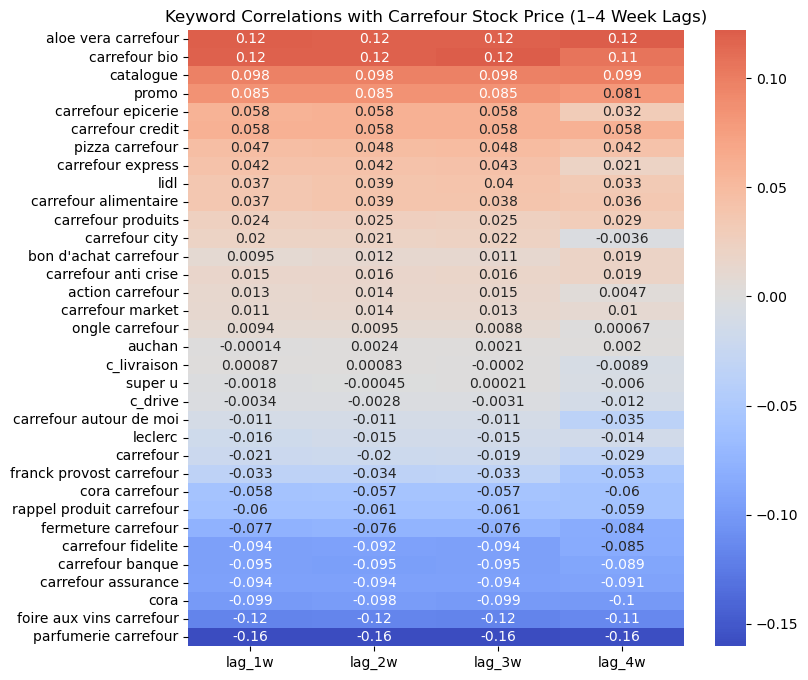

In [88]:
#plotting keywords lagged correlations in a seaborn heatmap for easier analysis.
keywords = df_svi_corrs.max(axis=1).sort_values(ascending=False).index.drop('Carrefour_Close')
plt.figure(figsize=(8, 8))
sns.heatmap(df_svi_corrs.loc[keywords], annot=True, cmap="coolwarm", center=0)
plt.title("Keyword Correlations with Carrefour Stock Price (1–4 Week Lags)")
plt.savefig('kw_lagged_corr.png', bbox_inches='tight', dpi=300) #save figure as png
plt.show()


Instead of trying only 1 1-week lag, we tested a 4-week lag. This allows us to test behavioural lag hypotheses and account for stock market delay.

1. Behavioural Lag Hypothesis

> Consumers search → consider options → purchase → company revenue impact → market reacts.

This chain can take 1–3 weeks, especially for FMCG, where buying cycles are short but not instant.

2. Stock Market Delay

Search volume might only impact stock performance when it gets amplified through news or earnings guidance. As such, investors may not immediately react to changes in consumer sentiment, especially if signals are subtle or not widely reported. 

*Note: Each lag shortens the dataset. As our dataset spans ~176 weeks, using lags of 5 or more would result in too few observations.* 

##### **Key Insights**

This lagged correlation analysis underscores that only a select subset of search trends demonstrate meaningful relationships with stock performance. The most informative signals are tied to health-focused products, promotional activity, and consumer-driven retail interest, although their strength remains modest. Lag dynamics further suggest that some search terms may act as short-term leading indicators in the FMCG context.

**1. Mild Predictors of Stock Price (r ≈ 0.12):**

While no keyword exhibited a strong correlation (r > 0.5), a few consistently maintained positive correlations near 0.12, particularly:
* `aloe vera carrefour`: stable across all lags, peaking at r = 0.122 at lag 4w, suggests that interest in health-related products may reflect slowly materialising consumer trends that mildly align with performance.
* `carrefour bio`: highest correlation at lag 3w (r = 0.121), indicating delayed alignment between organic product interest and financial results.
* `catalogue` and `promo`: maintained small but stable correlations, reflecting attention to promotional materials, which may track with sales or event cycles.

These signals, while statistically weak, may be qualitatively relevant for anticipating demand-side behaviour.

**2. Lag timing matters:**
- Most positive correlations peak at lag 3 or 4 weeks, notably for `carrefour bio`, `aloe vera carrefour`, and `bon d’achat carrefour`. This timing supports the view that consumer search behaviour leads stock price movements by several weeks.
- Keywords like `pizza carrefour` and `carrefour epicerie` showed minor weekly increases, suggesting short-lived effects or impulse-driven interest that fades quickly.

These findings reinforce the use of time-lagged models to exploit the predictive window of consumer search behaviour.

**3. Weak or negative correlations:**
- Keywords such as `carrefour autour de moi`, `fermeture carrefour`, and `carrefour` exhibited negative or near-zero correlations, consistent across lags. These terms likely reflect localized, operational, or sentiment-driven noise.
- `parfumerie carrefour` showed the most stable negative correlation (around -0.16), suggesting non-core or discretionary retail attention may inversely reflect investor sentiment, possibly due to perceived inefficiency or over-diversification.
- Other weak signals (`cora`, `carrefour assurance`, `carrefour fidelite`) may not translate into meaningful financial insights, even at longer lags.


## Prediction

### OLS regression with lagged SVI terms (as a baseline)

#### Lag 2

In [90]:
# Set lag
lag = 2

We set the lag at 2 weeks, as we have observed from the lagged correlation analysis that weeks 2 and 3 exhibit the highest predictor capabilities.

In [91]:
#Exclude the target
svi_columns = [col for col in df_trans.columns if col != 'Carrefour_Close']

In [92]:
#create lagged predictions
df_lagged = df_trans.copy()
for kw in svi_columns:
    df_lagged[f'{kw}_lag{lag}'] = df_lagged[kw].shift(lag)

In [93]:
# Create df for regression
lagged_cols = [f'{kw}_lag{lag}' for kw in svi_columns]
df_reg = df_lagged[lagged_cols + ['Carrefour_Close']].dropna()

In [94]:
#Define independent (X) and dependent (y) variables
X = sm.add_constant(df_reg[lagged_cols])
y = df_reg['Carrefour_Close']

In [95]:
# Fit the model
ols_model = sm.OLS(y, X).fit()

In [96]:
# View summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:        Carrefour_Close   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                 -0.088
Method:                 Least Squares   F-statistic:                    0.5924
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.962
Time:                        08:18:10   Log-Likelihood:                -121.75
No. Observations:                 173   AIC:                             313.5
Df Residuals:                     138   BIC:                             423.9
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### Lag 3

In [97]:
# Set lag
lag = 3

We set the lag at 3 weeks, as we observed from the lagged correlation analysis that weeks 2 and 3 have the highest predictor capabilities.

In [98]:
#Exclude the target
svi_columns = [col for col in df_trans.columns if col != 'Carrefour_Close']

In [99]:
#create lagged predictions
df_lagged = df_trans.copy()
for kw in svi_columns:
    df_lagged[f'{kw}_lag{lag}'] = df_lagged[kw].shift(lag)

In [100]:
# Create df for regression
lagged_cols = [f'{kw}_lag{lag}' for kw in svi_columns]
df_reg = df_lagged[lagged_cols + ['Carrefour_Close']].dropna()

In [101]:
#Define independent (X) and dependent (y) variables
X = sm.add_constant(df_reg[lagged_cols])
y = df_reg['Carrefour_Close']

In [102]:
# Fit the model
ols_model = sm.OLS(y, X).fit()

In [103]:
# View summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:        Carrefour_Close   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                 -0.094
Method:                 Least Squares   F-statistic:                    0.5683
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.972
Time:                        08:18:10   Log-Likelihood:                -121.76
No. Observations:                 172   AIC:                             313.5
Df Residuals:                     137   BIC:                             423.7
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Granger causality test
to see which keywords might be included in a VAR

In [104]:
from statsmodels.tsa.stattools import grangercausalitytests

In [105]:
# Ensure all series are aligned and no NaNs
df_gc = df_trans.dropna()

In [106]:
# Set max_lag — typically 2 to 4 weeks is appropriate for weekly data
max_lag = 4

In [107]:
# Store p-values for Granger causality in a dict
granger_results = {}

for col in df_gc.columns:
    if col != 'Carrefour_Close':
        test_result = grangercausalitytests(df_gc[[ 'Carrefour_Close', col ]], maxlag=max_lag, verbose=False)
        pvals = [round(test_result[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
        granger_results[col] = pvals


C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python3

In [108]:
# Convert results to DataFrame for easier viewing
granger_df = pd.DataFrame(granger_results, index=[f'lag_{i+1}' for i in range(max_lag)]).T


In [109]:
# Add column: minimum p-value across all lags
granger_df['min_pval'] = granger_df.min(axis=1)

In [110]:
# Sort by significance
granger_df_sorted = granger_df.sort_values(by='min_pval')


In [111]:
# Display keywords that Granger-cause Carrefour stock price at 5% level
significant_granger = granger_df_sorted[granger_df_sorted['min_pval'] <= 0.10]

In [112]:
significant_granger

,lag_1,lag_2,lag_3,lag_4,min_pval
aloe vera carrefour,0.0977,0.1346,0.1466,0.2031,0.0977


# Merged Datasets: Aggregated SVIs and Price Close Data.

### Merging Datasets: df_merged

In [113]:
df_merged = df_svi_agg.join(df_stock, how='inner')

In [114]:
df_merged.head()

,brand,service,sub-brand,fmcg,competitors,finance,news,Carrefour_Close,rolling_mean,rolling_std
date,,,,,,,,,,
2022-01-07,31.0,44.416667,32.25,16.1,35.125,31.4,12.000000,16.370110,NaN,NaN
2022-01-14,27.5,42.083333,31.00,15.1,32.500,29.8,11.000000,15.754726,NaN,NaN
2022-01-21,26.0,38.833333,30.50,14.4,34.125,28.8,10.333333,15.661081,NaN,NaN
2022-01-28,28.5,41.416667,29.50,17.9,36.125,31.0,9.666667,15.937558,15.930869,0.314531
2022-02-04,28.0,38.250000,29.75,21.2,37.125,30.8,12.333333,14.956510,15.577469,0.429599


In [115]:
df_merged = df_merged.drop(columns=[ "rolling_mean", "rolling_std"])

In [116]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2022-01-07 to 2025-05-16
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            176 non-null    float64
 1   service          176 non-null    float64
 2   sub-brand        176 non-null    float64
 3   fmcg             176 non-null    float64
 4   competitors      176 non-null    float64
 5   finance          176 non-null    float64
 6   news             176 non-null    float64
 7   Carrefour_Close  176 non-null    float64
dtypes: float64(8)
memory usage: 12.4 KB


##### Summary Statistics

In [117]:
# Get summary statistics
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,176.0,32.099432,5.295286,23.500,28.000000,31.000000,35.000000,50.500000
service,176.0,32.191761,6.124816,21.000,26.333333,33.166667,37.270833,44.583333
sub-brand,176.0,33.781250,8.508677,18.500,28.687500,33.250000,37.562500,57.250000
fmcg,176.0,18.111364,2.640711,12.000,16.275000,17.500000,19.700000,26.000000
competitors,176.0,40.322443,6.330262,30.375,35.968750,39.062500,42.906250,63.375000
finance,176.0,30.094318,4.268258,22.400,25.800000,31.200000,33.450000,37.600000
news,176.0,14.651515,5.209249,8.000,11.250000,13.000000,16.666667,36.333333
Carrefour_Close,176.0,15.283888,1.249030,12.510,14.403750,15.214428,16.086926,18.755840


###  Stationarity Tests

In [118]:
# Apply ADF test
def adf_test(series):
    try:
        result = adfuller(series.dropna(), autolag='AIC')
        return result[1]  # p-value
    except:
        return None

In [119]:
# Apply KPSS test
def kpss_test(series):
    try:
        result = kpss(series.dropna(), regression='c', nlags='auto')
        return result[1]  # p-value
    except:
        return None
        

In [120]:
# Create a summary DataFrame
stationarity_summary_agg = pd.DataFrame(columns=["ADF_pvalue", "KPSS_pvalue", "ADF_Stationary", "KPSS_Stationary"])

In [121]:
# Loop through each column in the DataFrame
for col in df_merged.columns:
    adf_p = adf_test(df_merged[col])
    kpss_p = kpss_test(df_merged[col])
    
    stationarity_summary_agg.loc[col] = [
        adf_p,
        kpss_p,
        "Yes" if adf_p < 0.05 else "No", #is it stationary? Stationary (p < 0.05) 
        "Yes" if kpss_p > 0.05 else "No" #is it stationary? Stationary (p > 0.05)
    ]

C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\jadem\AppData\Local\Temp\ipykernel_12468\3381259987.py:4: InterpolationWarning: The test statistic i

In [122]:
# Display results
stationarity_summary_agg

,ADF_pvalue,KPSS_pvalue,ADF_Stationary,KPSS_Stationary
brand,6.218859e-11,0.076574,Yes,Yes
service,9.690511e-01,0.010000,No,No
sub-brand,1.364937e-01,0.010000,No,No
fmcg,3.773914e-11,0.086961,Yes,Yes
competitors,9.775674e-11,0.042233,Yes,No
finance,5.184308e-01,0.010000,No,No
news,1.032207e-02,0.044464,Yes,No
Carrefour_Close,1.344312e-01,0.010000,No,No


**Which keywords are stationary?**

`brand`, `fmcg`

**Which keywords are non-stationary?**

`service`, `sub-brand`, `finance`, **`Carrefour_Close`**.

**Inconclusive tests**

`competitors`, `news`.

#### Assessing inconclusive tests

##### Visual Inspection

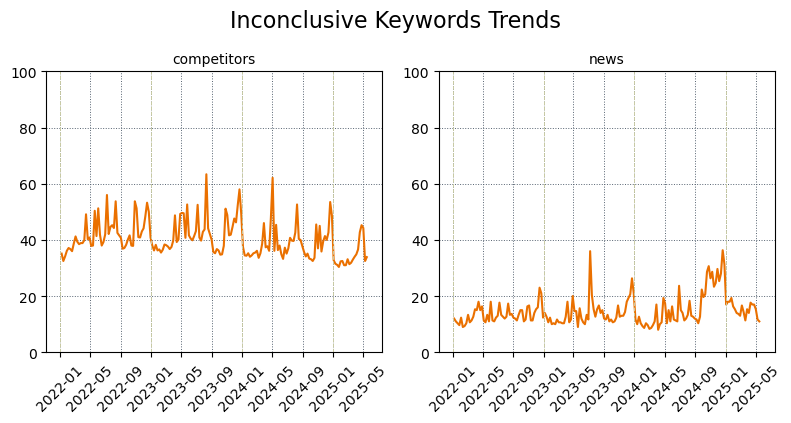

In [123]:
#plot inconclusive tests
#`competitors`, `news`.

#list of inconclusive keywords
inconclusive2 = ["competitors", "news"]

n_cols = 2
n_rows = int(np.ceil(len(inconclusive) / n_cols))

plt.figure(figsize=(8, 14))

for i, keyword in enumerate(inconclusive2):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(df_merged.index, df_merged[keyword], color='#EA7000')
    for year in range(2022, 2026):
        plt.axvline(pd.to_datetime(f"{year}-01-01"), color='#C9CBA3', linestyle='--', linewidth=0.7)
    plt.grid(True, which='both', axis='both', linestyle=':', linewidth=0.7, color='#556270')
    plt.title(keyword, fontsize=10)
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("Inconclusive Keywords Trends", fontsize=16, y=1.02)

#save figure as PNG
plt.savefig('inconclusive_trends.png', bbox_inches='tight', dpi=300)

plt.show()

Visual inspection of the inconclusive variables reveals a range of behaviours:
- `competitors` shows some signs of seasonality
- `news` has some variance shifts

However to confirm this a different stationary test will be carried out.

##### Try the Phillips-Perron test

In [124]:
from arch.unitroot import PhillipsPerron

In [125]:
def pp_test(series):
    try:
        result = PhillipsPerron(series.dropna())
        return result.pvalue, result.stat
    except:
        return None, None

In [126]:
# Create a new summary DataFrame
pp_results = pd.DataFrame(columns=["PP_pvalue", "PP_stat", "PP_Stationary"])

In [127]:
# Apply to inconclusive series
inconclusive_cols2 = ["competitors", "news"]

for col in inconclusive_cols2:
    p_val, stat = pp_test(df_merged[col])
    pp_results.loc[col] = [
        p_val,
        stat,
        "Yes" if p_val is not None and p_val < 0.05 else "No"
    ]

In [128]:
# Display result
pp_results

,PP_pvalue,PP_stat,PP_Stationary
competitors,8.371928e-11,-7.383101,Yes
news,6.465830e-09,-6.608489,Yes


Despite earlier ambiguity (e.g., KPSS at boundary values or visual uncertainty), the PP test rejects the null hypothesis of non-stationarity for each one, with extremely low p-values and strongly negative test statistics.


#### Transformation of non-stationary data

##### Non-stationary keywords:
`service`, `sub-brand`, `finance`, `Carrefour_Close`.

**First-Order Differencing**

In [130]:
#create a non-stationary list
non_stat_cols2 = [ "service", "sub-brand", "finance", "Carrefour_Close" ]

#Apply First-Order Differencing
df_diff2 = df_merged[non_stat_cols2].diff().dropna()


In [131]:
#Drop original non-stationary columns from the original DataFrame
df_trans2 = df_merged.drop(columns=non_stat_cols2)

#Merge the differenced columns back in
df_trans2 = pd.concat([df_trans2, df_diff2], axis=1)

#Drop NaN values from the first row due to differencing
df_trans2 = df_trans2.dropna()

# Preview
print(f"df_trans2 shape: {df_trans2.shape}")
df_trans2.head()



df_trans2 shape: (175, 8)


,brand,fmcg,competitors,news,service,sub-brand,finance,Carrefour_Close
date,,,,,,,,
2022-01-14,27.5,15.1,32.500,11.000000,-2.333333,-1.25,-1.6,-0.615383
2022-01-21,26.0,14.4,34.125,10.333333,-3.250000,-0.50,-1.0,-0.093645
2022-01-28,28.5,17.9,36.125,9.666667,2.583333,-1.00,2.2,0.276477
2022-02-04,28.0,21.2,37.125,12.333333,-3.166667,0.25,-0.2,-0.981049
2022-02-11,28.5,19.6,36.750,9.000000,-1.166667,0.25,-0.4,0.329989


`df_trans2` is now fully stationary, ready for correlation, causality, or time series modelling.

### Correlation Analysis

To identify whether changes in consumer search behaviour (via SVI grouped by keyword category) are associated with Carrefour’s stock price performance. This supports the hypothesis that digital attention may signal financial outcomes.

* Pearson correlation tests linear relationships between variables.
* Spearman correlation detects monotonic relationships, useful for nonlinear or skewed data (as some of the keywords are highly skewed and migth imact ).
* Lagged correlation helps explore predictive power—i.e., whether search behaviour precedes changes in stock price.

This analysis helps validate whether digital attention is an informational indicator or just noise.

In [132]:
# Pearson correlation matrix
pearson = df_trans2.corr(method='pearson')['Carrefour_Close'].drop('Carrefour_Close')
print("Pearson Correlations:")
print(pearson.sort_values(ascending=False))

Pearson Correlations:
competitors    0.004736
service        0.000710
fmcg          -0.016644
sub-brand     -0.017104
brand         -0.025284
finance       -0.056653
news          -0.072799
Name: Carrefour_Close, dtype: float64


In [133]:
# Spearman correlation matrix
spearman = df_trans2.corr(method='spearman')['Carrefour_Close'].drop('Carrefour_Close')
print("\nSpearman Correlations:")
print(spearman.sort_values(ascending=False))


Spearman Correlations:
fmcg           0.027629
competitors    0.017983
service        0.007929
brand         -0.015739
sub-brand     -0.028391
finance       -0.034790
news          -0.055141
Name: Carrefour_Close, dtype: float64


The post-transformation analysis of keyword category correlations with Carrefour’s weekly stock returns reveals a striking shift. After correcting for non-stationarity, no category exhibits meaningful correlation, suggesting that digital attention alone may not reliably signal financial fluctuations without accounting for lag effects or external variables.

| *Category*    | *Pearson* | *Spearman* | *Interpretation*  |
| ------------- | :-------: | :--------: | ----------------- |
| `competitors` |   0.005   |    0.018   | **No meaningful relationship**. Any previously observed alignment is likely to have stemmed from broader market co-trends rather than direct influence.  |
| `service` | 0.001 | 0.008 | **Completely diminished**. Once the strongest category, now indicates **no short-term signal** after correcting for trend. |
| `fmcg` | -0.017 |  0.028 | **Mixed and weak**. General consumer product interest does not appear to drive weekly stock variation post-transformation. |
| `sub-brand` |   -0.017  |   -0.028   | **Lost predictive power**. Interest in Carrefour’s sub-brands (Bio, Market) does not align with short-term financial shifts.|
| `brand` | -0.025  |   -0.016   | **Still weak**. Brand-level searches remain insufficient to explain or predict stock movement. |
| `finance` | -0.057  |   -0.035   | **Negative signal**. May reflect consumer unease or decoupling of banking operations from retail investor sentiment. |
| `news` |   -0.073  |   -0.055   | **Most consistently negative**. Likely reflects crisis attention or market-sensitive headlines that align with declining investor confidence. |

### Lagged Analysis

>*Does an increase (or decrease) in search volume for specific keyword categories precede a corresponding movement in Carrefour’s stock price?*

In [134]:
keyword_cols = ['brand', 'service', 'sub-brand', 'fmcg', 'competitors', 'finance', 'news']
lags = [1, 2, 3, 4]  # 4 weeks lag

# Dictionary to store correlations for each lag
lagged_correlations = {}

for lag in lags:
    df_lag = df_trans2.copy()
    df_lag[keyword_cols] = df_lag[keyword_cols].shift(lag)
    df_lag = df_lag.dropna()
    
    corr = df_lag.corr(method='pearson')['Carrefour_Close'].drop('Carrefour_Close')
    lagged_correlations[f'Lag_{lag}w'] = corr
    
df_agg_corrs = pd.DataFrame(lagged_correlations)

In [135]:
# Convert to DataFrame for comparison and print dataframe
comparison_df = pd.DataFrame(lagged_correlations)
print("\nComparison of Lagged Pearson Correlations:")
print(comparison_df.sort_values('Lag_1w', ascending=False))


Comparison of Lagged Pearson Correlations:
               Lag_1w    Lag_2w    Lag_3w    Lag_4w
fmcg         0.015173  0.022031 -0.058010 -0.070419
competitors  0.002514  0.015430 -0.066767 -0.100547
finance     -0.001302  0.067911  0.017581 -0.054419
sub-brand   -0.001721  0.103800  0.030189 -0.052088
news        -0.013278  0.011638 -0.042938 -0.135915
brand       -0.021142  0.027136 -0.050435 -0.110260
service     -0.069381 -0.012789  0.065249 -0.092395


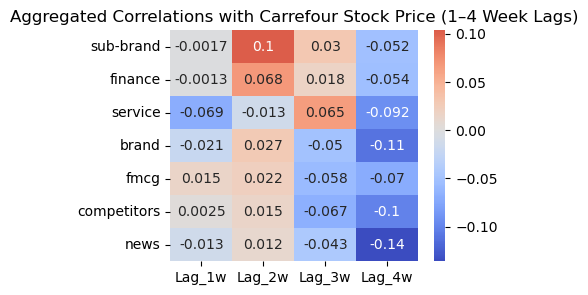

In [136]:
#plotting keywords lagged correlations in a seaborn heatmap for easier analysis.
agg_keywords = df_agg_corrs.max(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(4, 3))
sns.heatmap(df_agg_corrs.loc[agg_keywords], annot=True, cmap="coolwarm", center=0)
plt.title("Aggregated Correlations with Carrefour Stock Price (1–4 Week Lags)")
plt.savefig('agg_lagged_corr.png', bbox_inches='tight', dpi=300) #save figure as png
plt.show()

##### **Key Insights (Agg. Keyword Categories)**

This multi-layered analysis reveals that while raw correlations suggest compelling signals from service and finance-related searches, these relationships dissipate after stationarity corrections. However, some delayed effects persist in specific categories, suggesting nuanced, time-lagged dynamics between consumer digital behaviour and stock performance in the FMCG sector.

**1. Trend co-movements drove initial signals**

- In the non-transformed data, categories like `service` (r = 0.59) and `finance` (r = 0.51) exhibited strong positive correlations with Carrefour’s stock price.
- These associations largely disappeared after differencing, showing that the original signals were spurious correlations caused by shared upward trends rather than accurate behavioural predictors.

**2. After differencing, most categories lost predictive value**

| Category     | Pearson (Diff) | Spearman (Diff) | Interpretation |
|--------------|----------------|------------------|----------------|
| `service`, `finance`, `brand`, `sub-brand`, `fmcg` | All between -0.06 and +0.03 | No significant relationship remains | Removing trends revealed no meaningful short-term co-movement. |
| `news`       | -0.073         | -0.055           | Remains consistently negative, possibly indicating event- or crisis-driven sentiment linked to market caution. |

These results suggest that search interest alone does not predict weekly stock returns, unless tied to highly specific and time-sensitive behaviour.

**3. Lagged effects reveal weak but non-random signals**

- `sub-brand` and `finance` categories showed peak correlation at lag 2 weeks, with r = 0.10 and r = 0.07, respectively, post-transformation.
- `news` showed increasingly negative correlation, bottoming at r = -0.136 at lag 4w, implying that event-driven attention may act as a warning signal, not an opportunity.

| Category     | Lag with Peak | Max r | Interpretation |
|--------------|---------------|-------|----------------|
| `sub-brand`  | Lag 2w        | 0.104 | Short-term attention to Carrefour product lines may precede stock shifts. |
| `finance`    | Lag 2w        | 0.068 | Search interest in Carrefour Banque or credit may signal delayed investor response. |
| `news`       | Lag 4w        | -0.136| May reflect crisis sentiment, aligning with negative investor expectations. |

**4. Category-level insights align with individual keyword behaviours**

- At the individual level, keywords like `carrefour bio`, `aloe vera carrefour`, and `catalogue` maintained modest and consistent lagged correlations, especially around 2–3 weeks.
- This supports the sub-brand and promotional-driven lag effect observed at the aggregated level.
- Keywords related to banking, delivery, and promotions lost strength after differencing but exhibited minor rebound effects in lagged analysis, reinforcing the need for time-aware modelling.

## Prediction

### OLS regression with lagged aggregated SVI terms (as a baseline)

#### Lag 2

In [137]:
# Set lag
lag = 2

We set the lag at 2 weeks, as we have observed from the lagged correlation analysis that weeks 2 and 3 exhibit the highest predictor capabilities.

In [138]:
#Exclude the target
svi_columns2 = [col for col in df_trans2.columns if col != 'Carrefour_Close']

In [139]:
#create lagged predictions
df_lagged2 = df_trans2.copy()
for kw in svi_columns2:
    df_lagged2[f'{kw}_lag{lag}'] = df_lagged2[kw].shift(lag)

In [140]:
# Create df for regression
lagged_cols2 = [f'{kw}_lag{lag}' for kw in svi_columns2]
df_reg2 = df_lagged2[lagged_cols2 + ['Carrefour_Close']].dropna()

In [141]:
#Define independent (X) and dependent (y) variables
X = sm.add_constant(df_reg2[lagged_cols2])
y = df_reg2['Carrefour_Close']

In [142]:
# Fit the model
ols_model2 = sm.OLS(y, X).fit()

In [143]:
# View summary
print(ols_model2.summary())


                            OLS Regression Results                            
Dep. Variable:        Carrefour_Close   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.3389
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.935
Time:                        08:42:07   Log-Likelihood:                -132.30
No. Observations:                 173   AIC:                             280.6
Df Residuals:                     165   BIC:                             305.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1912      0.373  

#### Lag 3

In [144]:
# Set lag
lag = 3

In [145]:
#Exclude the target
svi_columns2 = [col for col in df_trans2.columns if col != 'Carrefour_Close']

In [146]:
#create lagged predictions
df_lagged2 = df_trans2.copy()
for kw in svi_columns2:
    df_lagged2[f'{kw}_lag{lag}'] = df_lagged2[kw].shift(lag)

In [147]:
# Create df for regression
lagged_cols2 = [f'{kw}_lag{lag}' for kw in svi_columns2]
df_reg2 = df_lagged2[lagged_cols2 + ['Carrefour_Close']].dropna()

In [148]:
#Define independent (X) and dependent (y) variables
X = sm.add_constant(df_reg2[lagged_cols2])
y = df_reg2['Carrefour_Close']

In [149]:
# Fit the model
ols_model2 = sm.OLS(y, X).fit()

In [150]:
# View summary
print(ols_model2.summary())


                            OLS Regression Results                            
Dep. Variable:        Carrefour_Close   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.4908
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.840
Time:                        08:42:07   Log-Likelihood:                -131.33
No. Observations:                 172   AIC:                             278.7
Df Residuals:                     164   BIC:                             303.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5510      0.373  

### Granger causality test
to see which keywords might be included in a VAR

In [151]:
# Ensure all series are aligned and no NaNs
df_gc2 = df_trans2.dropna()

In [152]:
# Set max_lag — typically 2 to 4 weeks is appropriate for weekly data
max_lag = 4

In [153]:
# Store p-values for Granger causality in a dict
granger_results2 = {}

for col in df_gc2.columns:
    if col != 'Carrefour_Close':
        test_result = grangercausalitytests(df_gc2[[ 'Carrefour_Close', col ]], maxlag=max_lag, verbose=False)
        pvals = [round(test_result[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
        granger_results2[col] = pvals


C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jadem\AppData\Roaming\Python\Python3

In [154]:
# Convert results to DataFrame for easier viewing
granger_df2 = pd.DataFrame(granger_results2, index=[f'lag_{i+1}' for i in range(max_lag)]).T


In [155]:
# Add column: minimum p-value across all lags
granger_df2['min_pval'] = granger_df2.min(axis=1)

In [156]:
# Sort by significance
granger_df_sorted2 = granger_df2.sort_values(by='min_pval')


In [157]:
granger_df_sorted2

,lag_1,lag_2,lag_3,lag_4,min_pval
news,0.7663,0.8849,0.8648,0.3356,0.3356
sub-brand,0.9575,0.3690,0.3442,0.4853,0.3442
service,0.3572,0.5813,0.7506,0.5508,0.3572
brand,0.7523,0.8477,0.7607,0.5364,0.5364
competitors,0.9610,0.9728,0.7064,0.5523,0.5523
finance,0.9049,0.7134,0.7959,0.9140,0.7134
fmcg,0.8586,0.9495,0.7756,0.7686,0.7686
